In [105]:
import pandas as pd
import numpy as np
from os import path
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

In [223]:
#Get the CSV file with all of our data
clean_data = pd.read_csv('data/cleaned/schwartau/schwartau.csv', encoding='UTF-8')

       flow  departures  arrivals  temperature     weight  humidity  \
83783  -940        3218      2278        34.57  74.620431  92.79375   

                 timestamp  
83783  2019-05-31 14:15:00  


In [226]:
#Alter timestamp data to reflect a circular distance from the beginning of the year
timestamps = np.array([x/clean_data.shape[0] for x in range(clean_data['timestamp'].shape[0])])

In [227]:
#Create a numpy array to store our features in
X = np.array([
    clean_data['flow'].values,
    clean_data['temperature'].values,
    clean_data['weight'].values,
    clean_data['humidity'].values
])

#Rotate array so that each row is an entry of features from each attribute
X = np.rot90(X, k=-1)

#Normalize using Min Max Scaler
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [242]:
#Let's try to find a good epsilon value
neighbors = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(X)
distances = np.array([])
for x in X:
    distances = np.append(distances, [neighbors.kneighbors([x])[0][0][1]])
epsilon = np.percentile(distances, 99.99)
print(f'Try epsilon value {epsilon}')

Try epsilon value 0.05186609576339765


In [246]:
#Get model
model = DBSCAN(eps=epsilon, min_samples=96, n_jobs=None, metric='euclidean').fit(X)
#Get labels
labels = model.labels_
#Print number of clusters
clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'There are {clusters} cluster(s)')

There are 5 cluster(s)


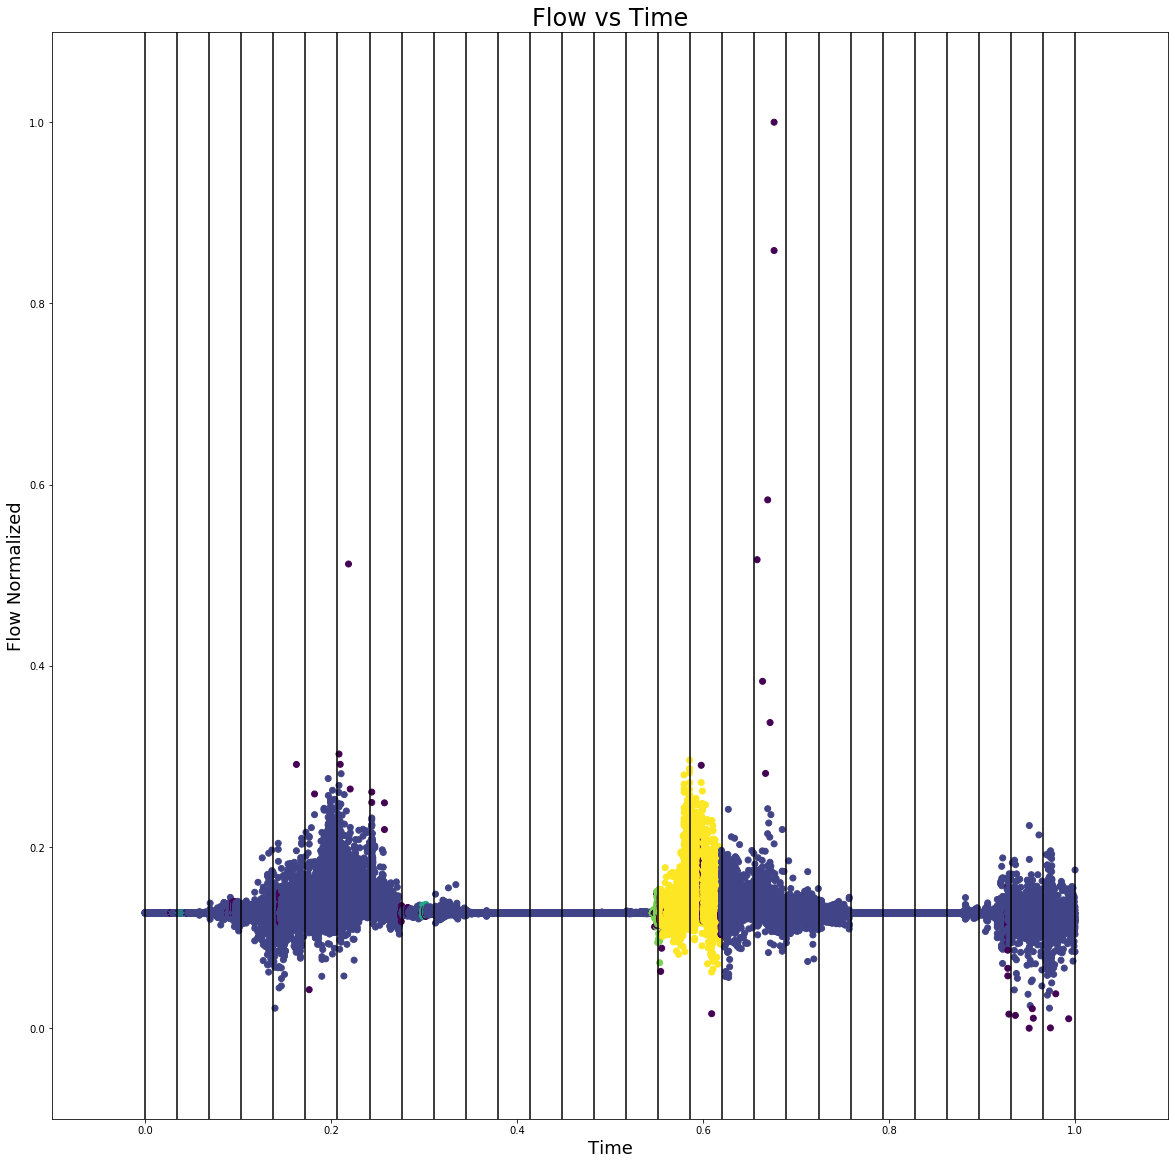

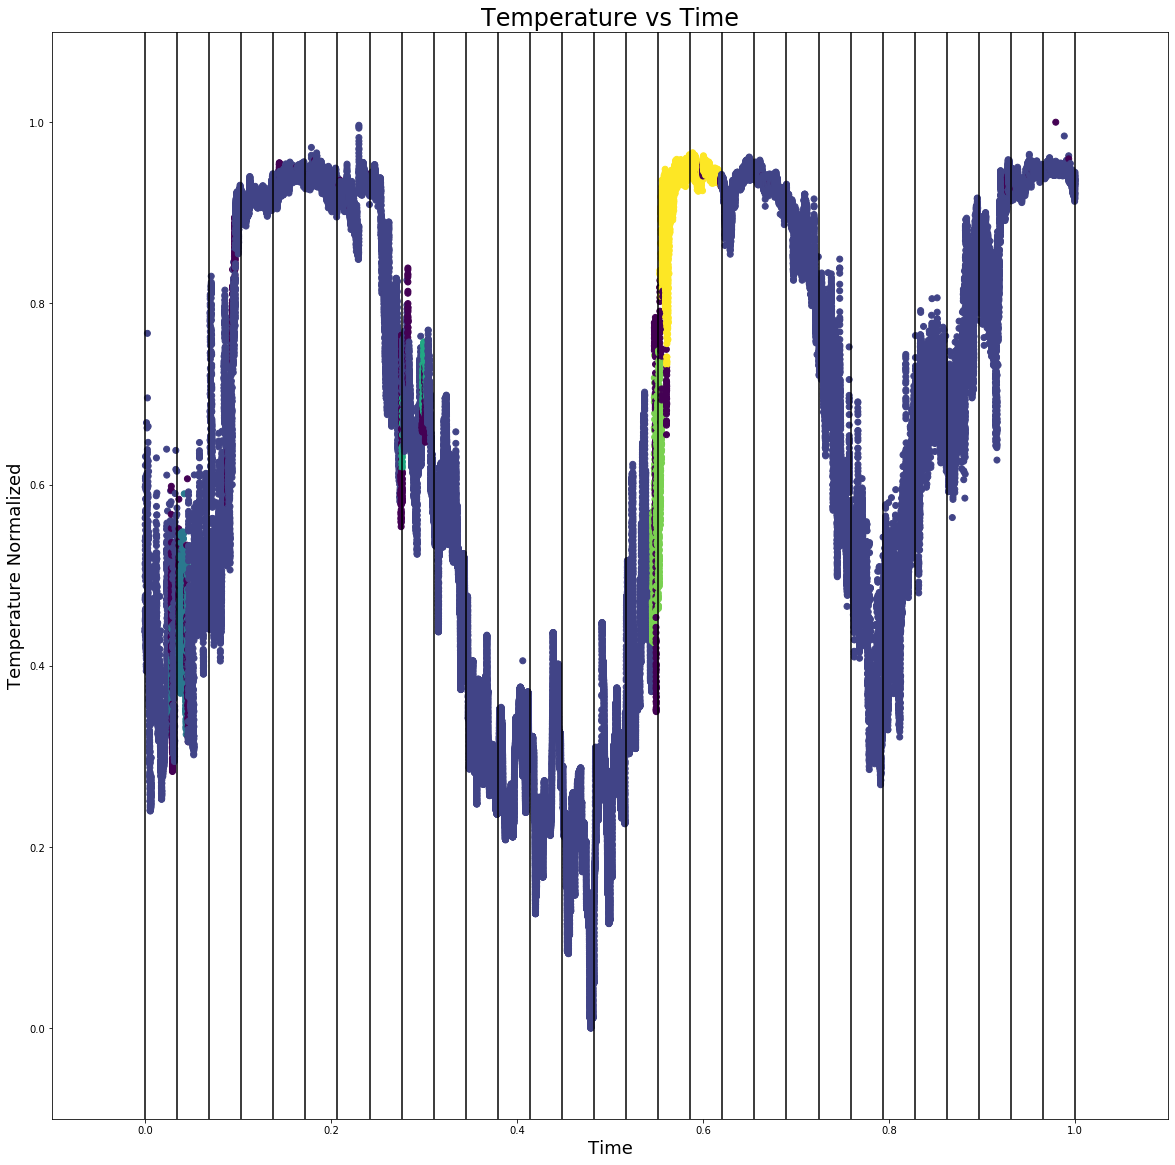

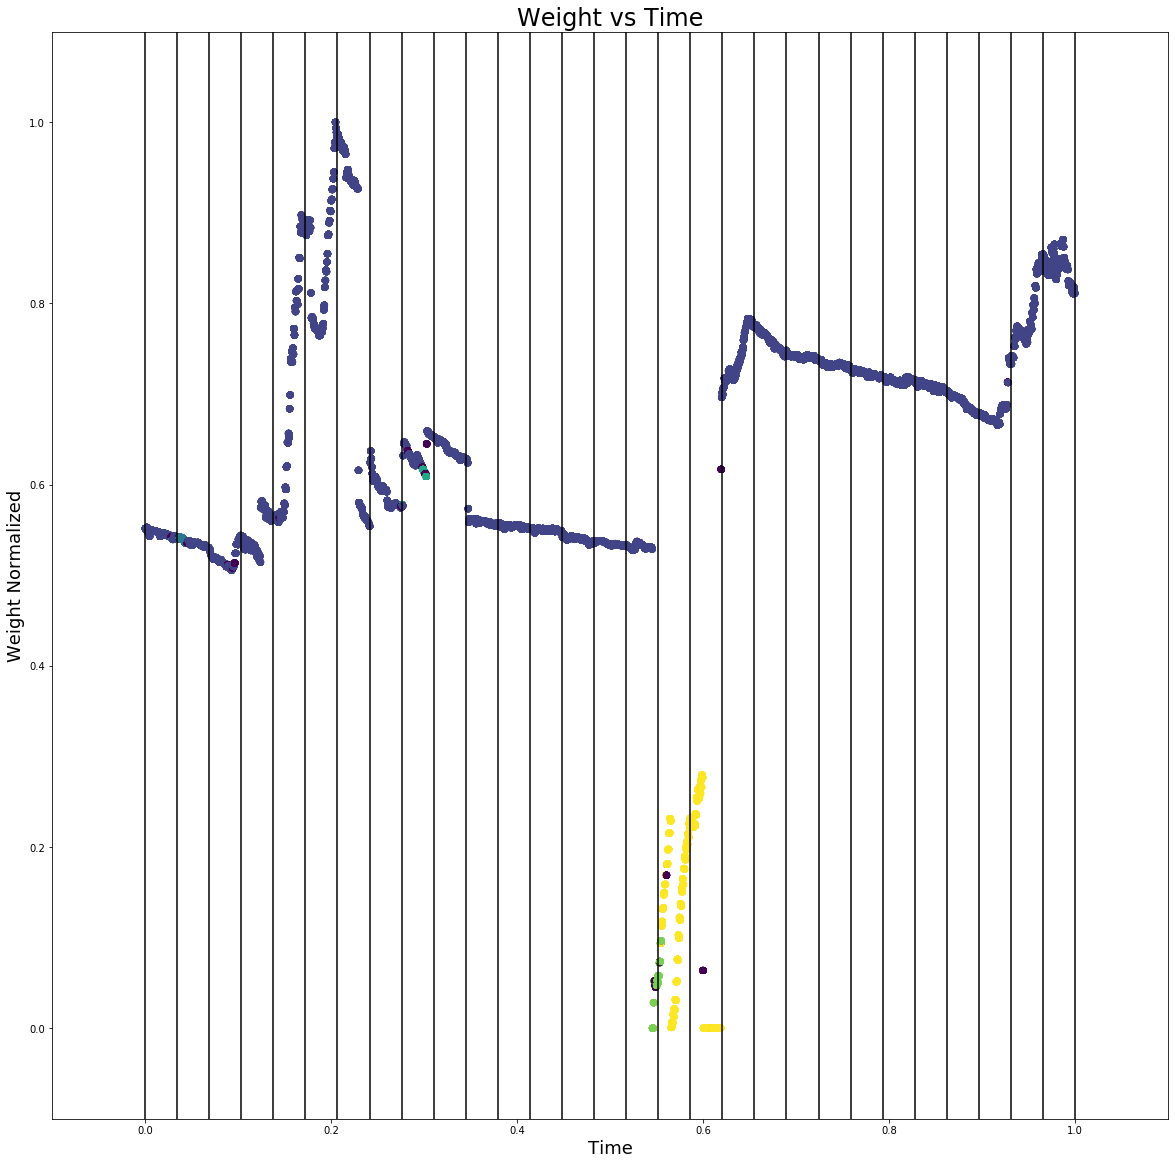

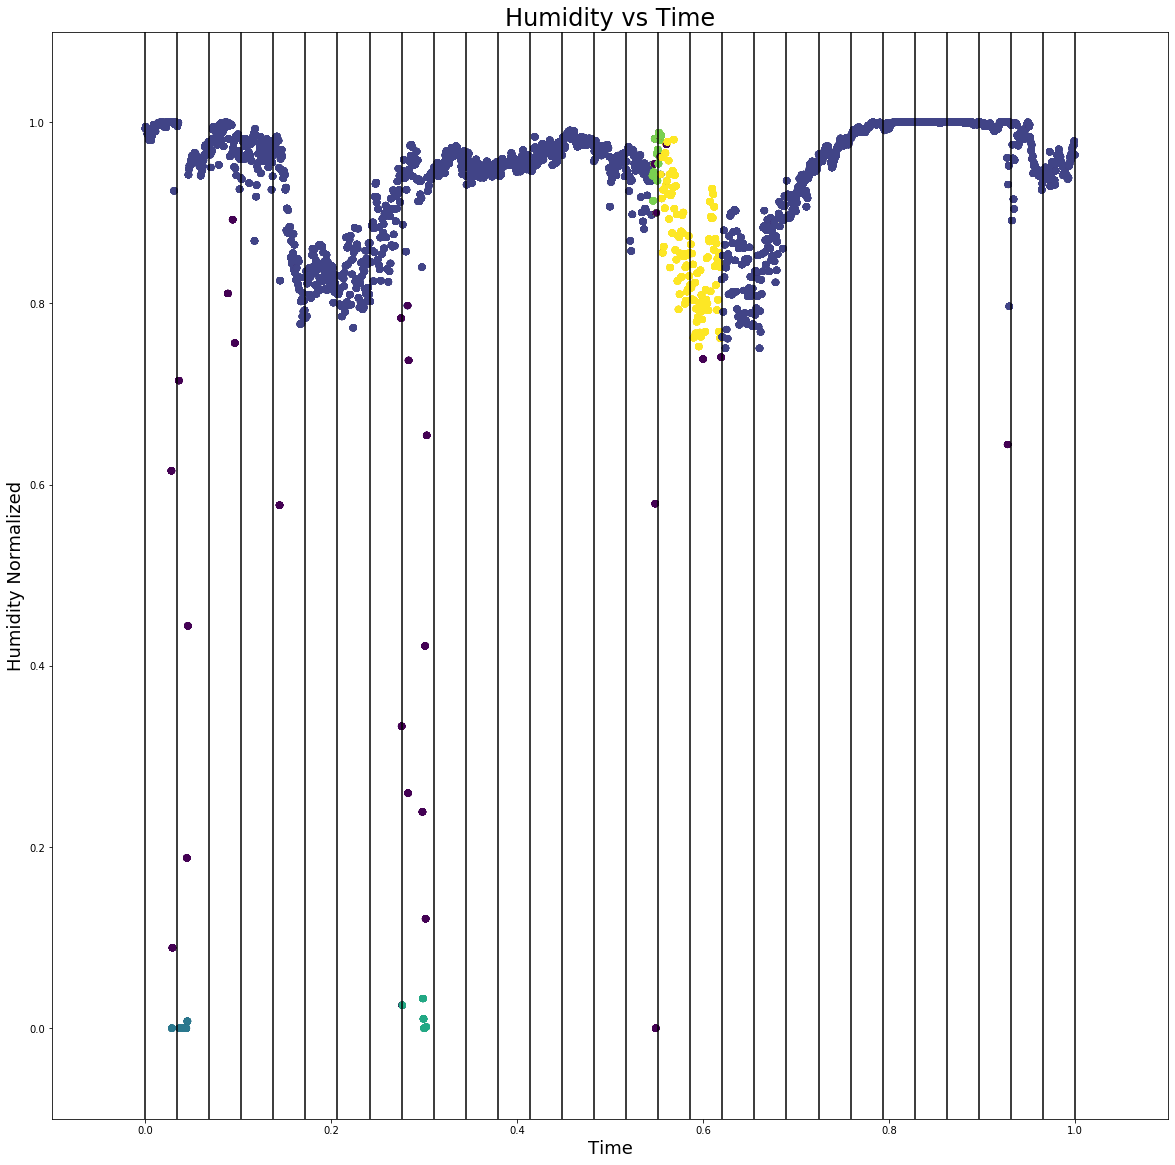

In [247]:
#Graph each attribute
for attribute, column in [['Flow', 3], ['Temperature', 2], ['Weight', 1], ['Humidity', 0]]:
    plt.figure(figsize=(20,20))
    plt.title(f'{attribute} vs Time', fontsize=24)
    plt.ylabel(f'{attribute} Normalized', fontsize=18)
    plt.xlabel('Time', fontsize=18)
    for i in range(30):
        plt.axvline(x=i/29, c='black')
    plt.xlim(right=1.1)
    plt.xlim(left=-0.1)
    plt.ylim(top=1.1)
    plt.ylim(bottom=-0.1)
    plt.scatter(timestamps, X[:,column], c=labels)

C:\Users\Sean\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


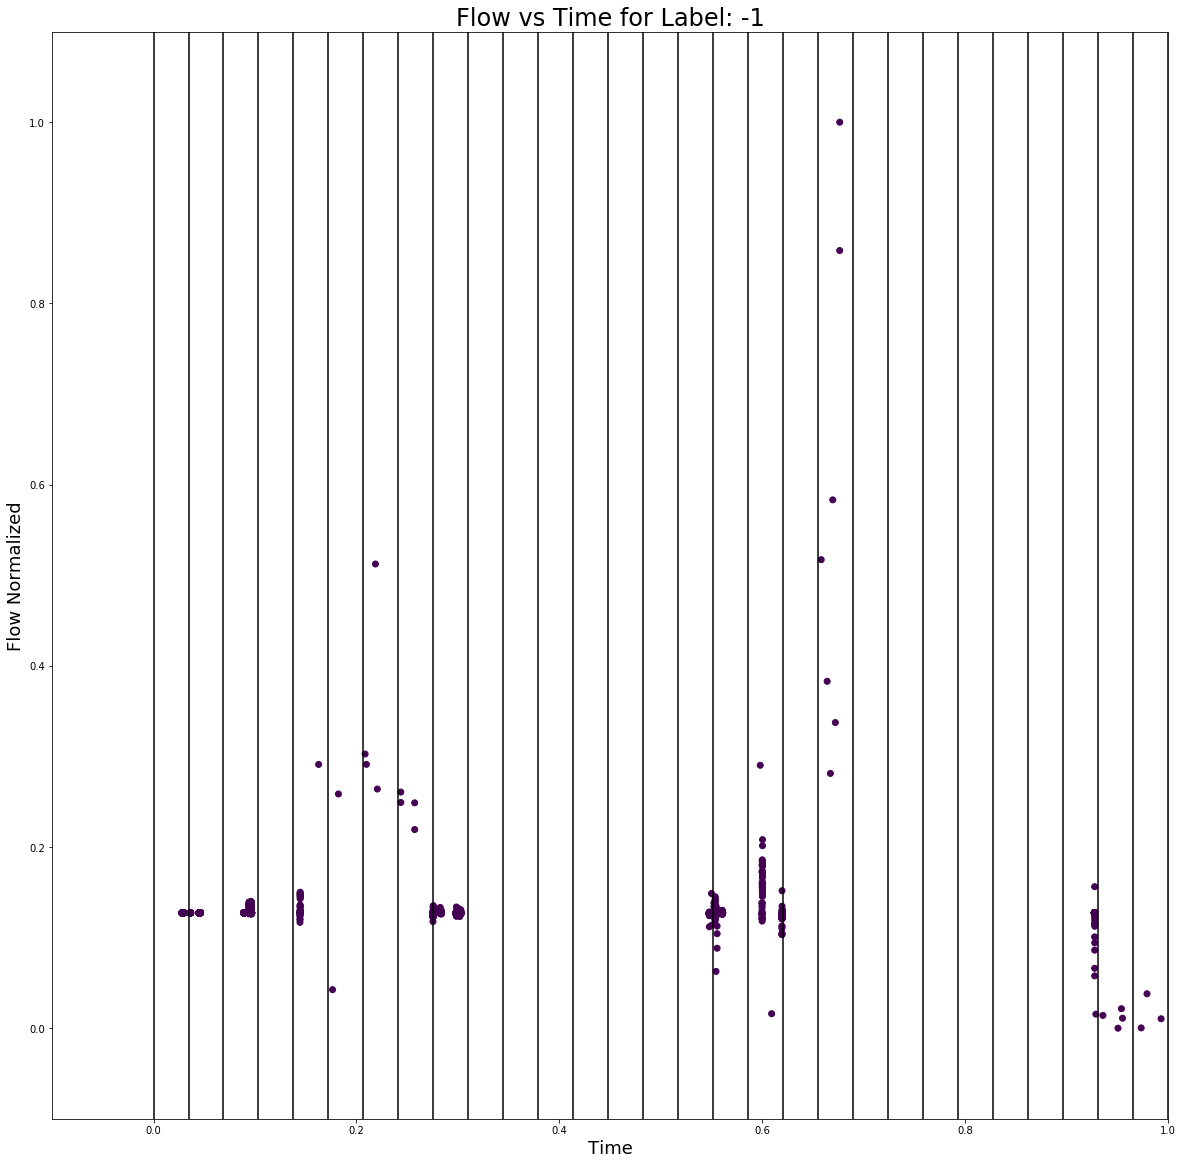

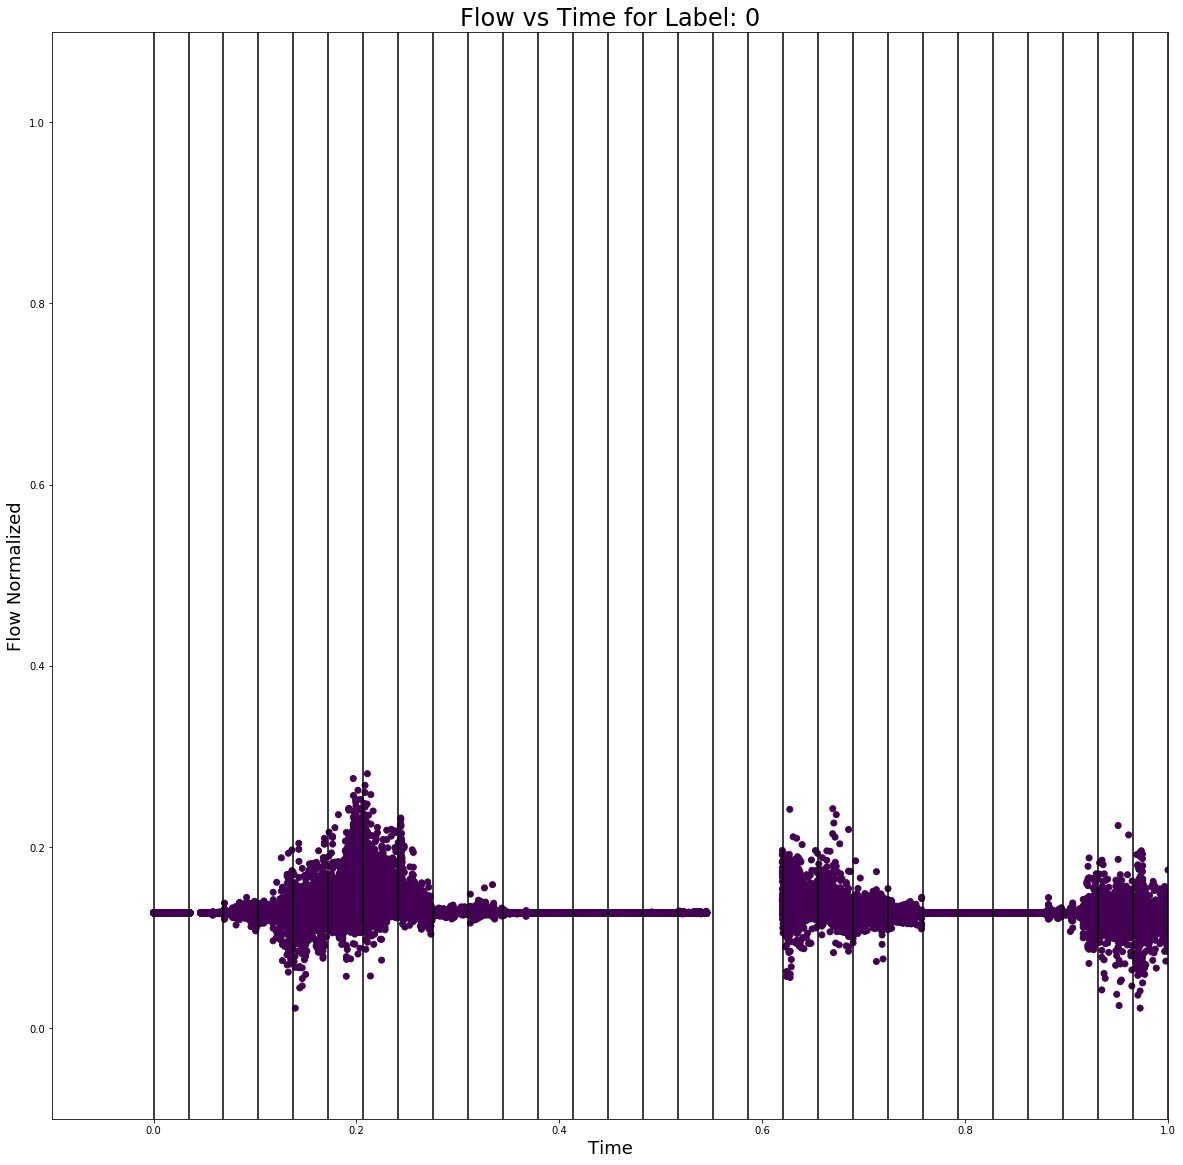

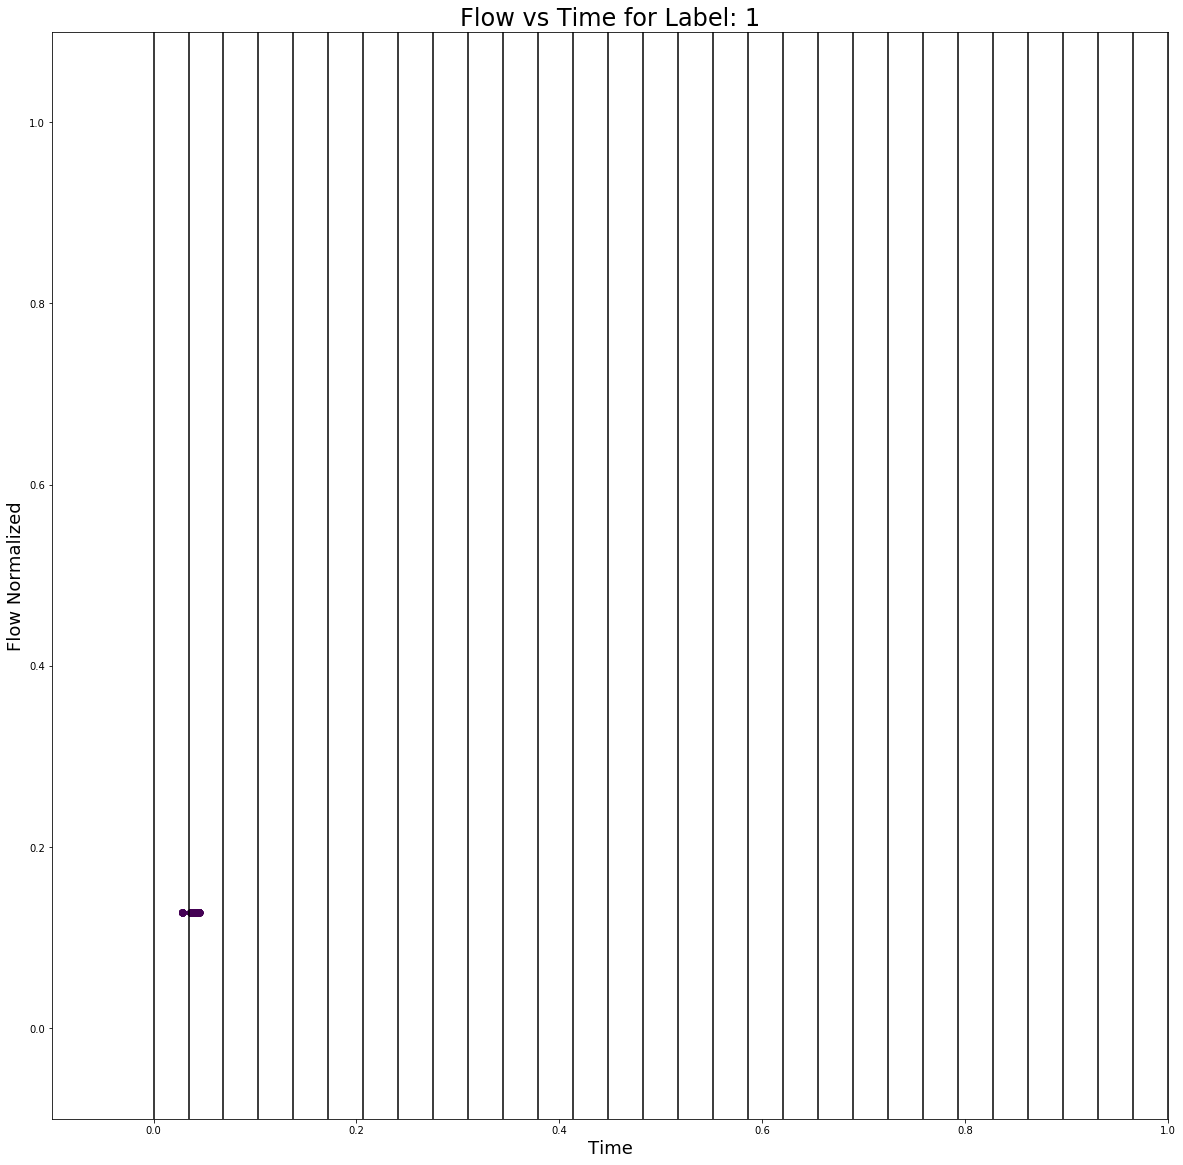

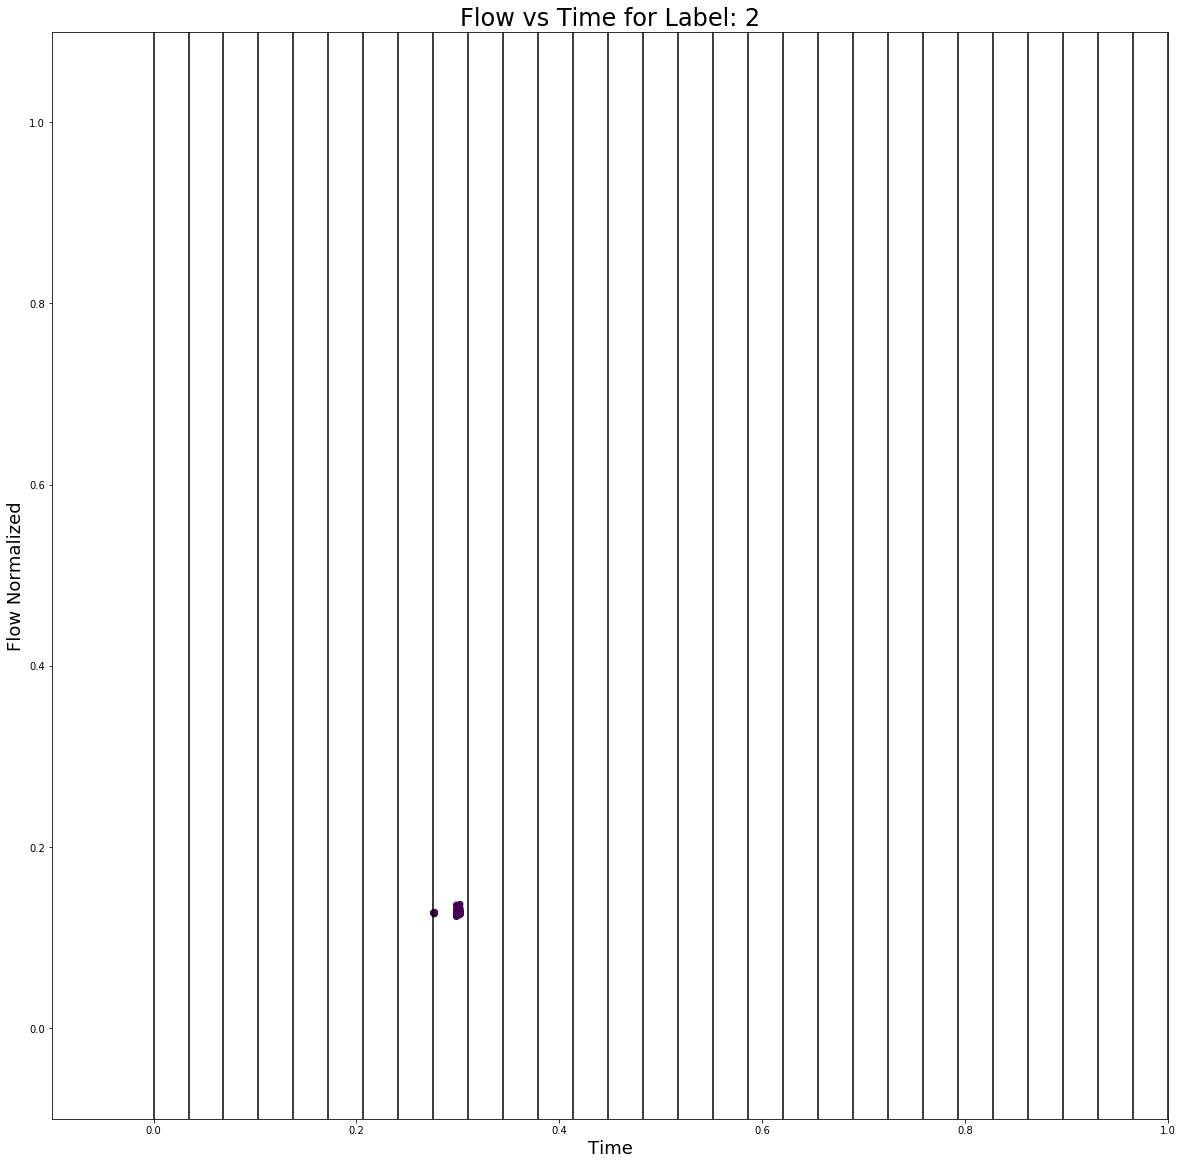

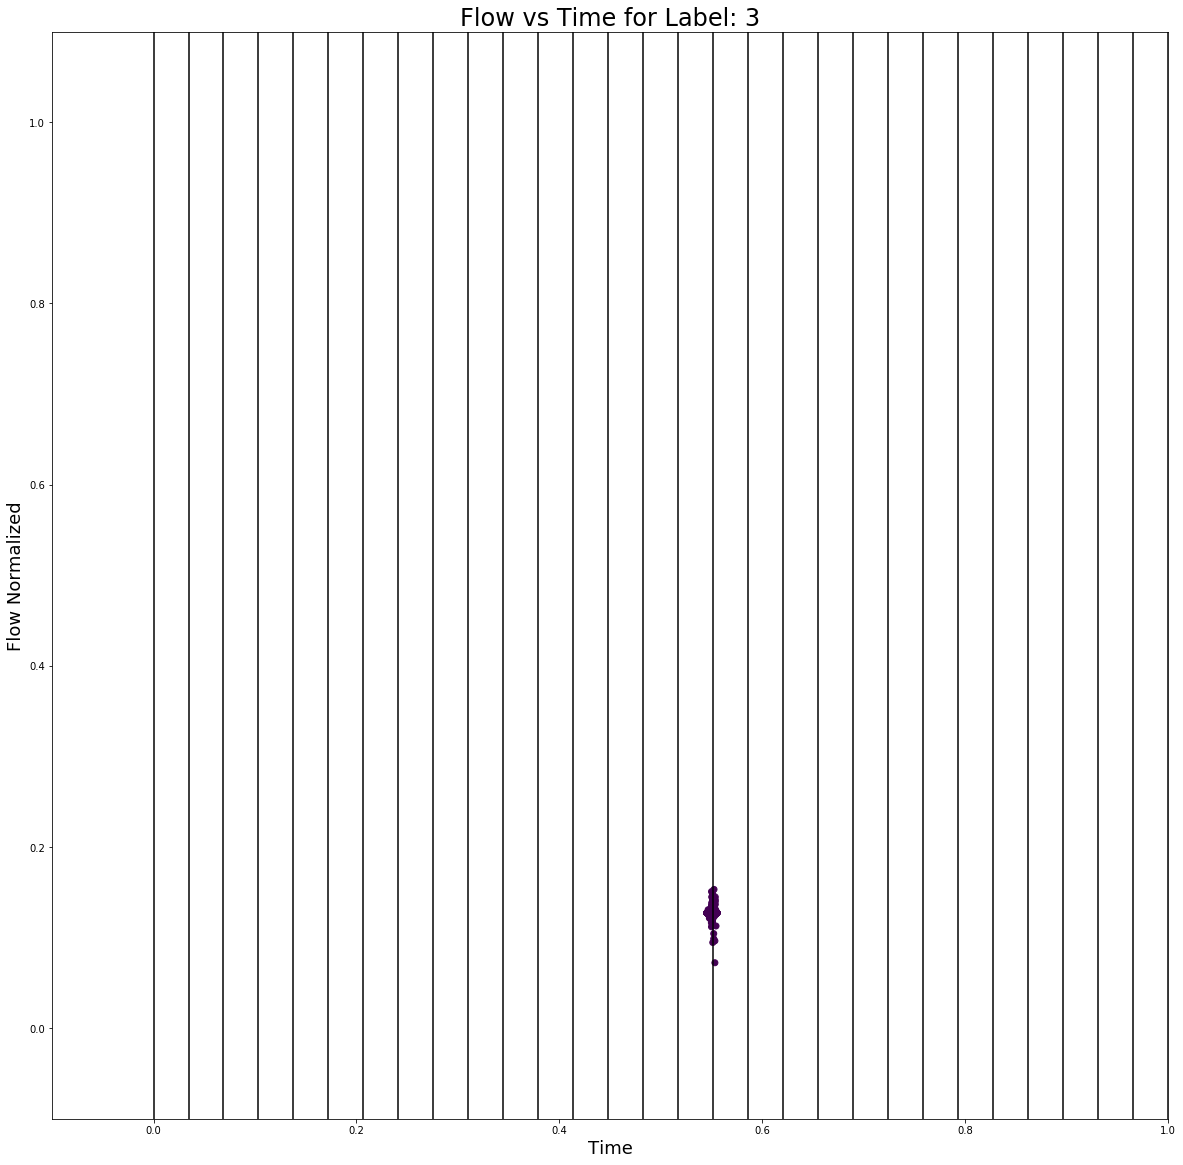

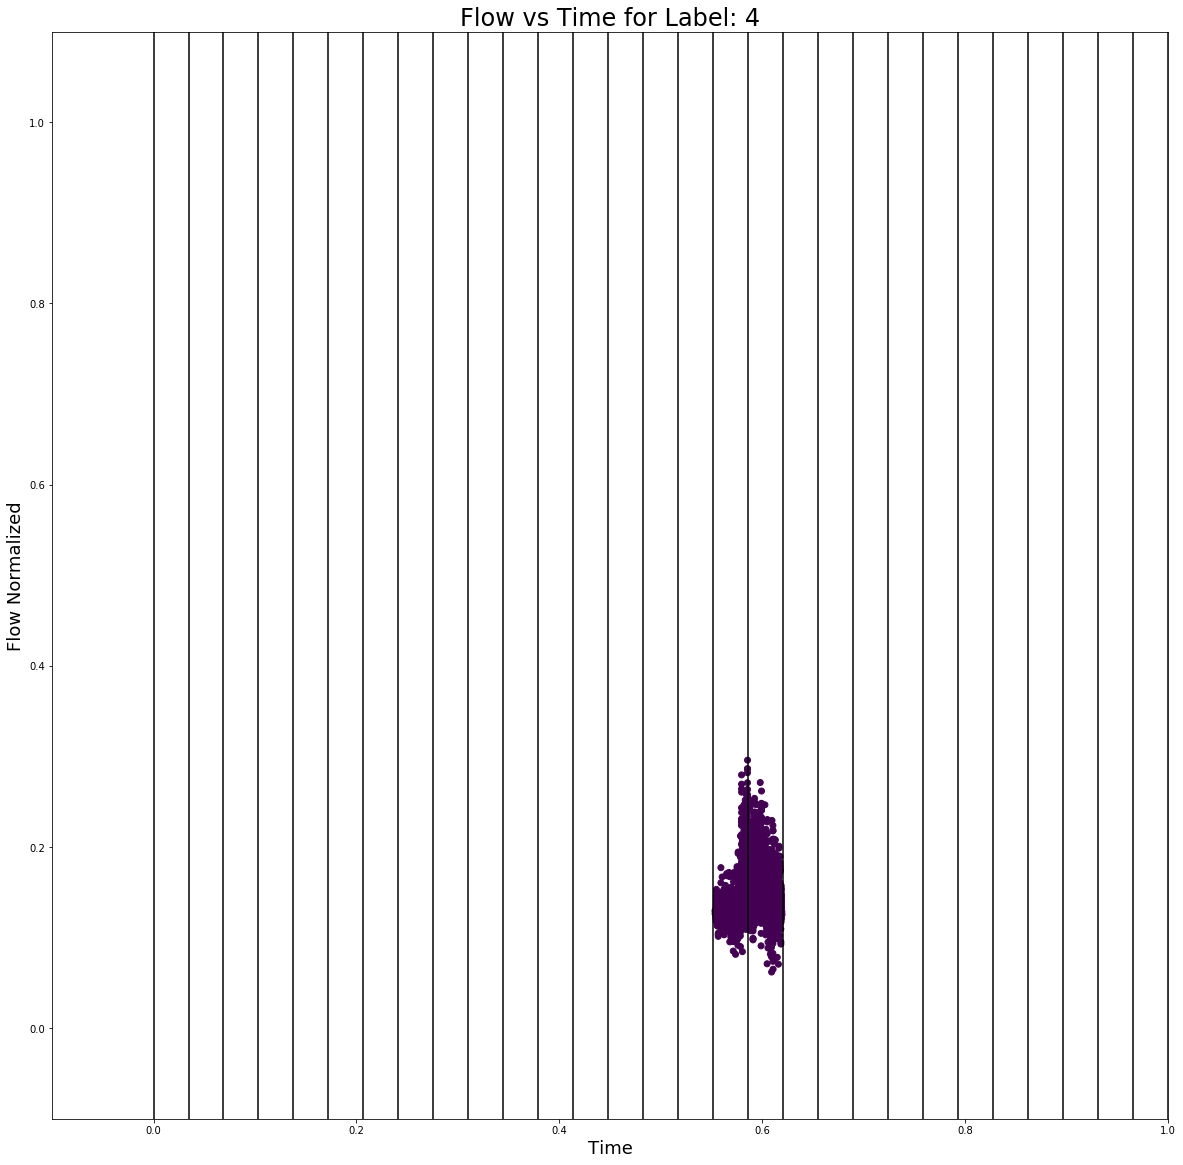

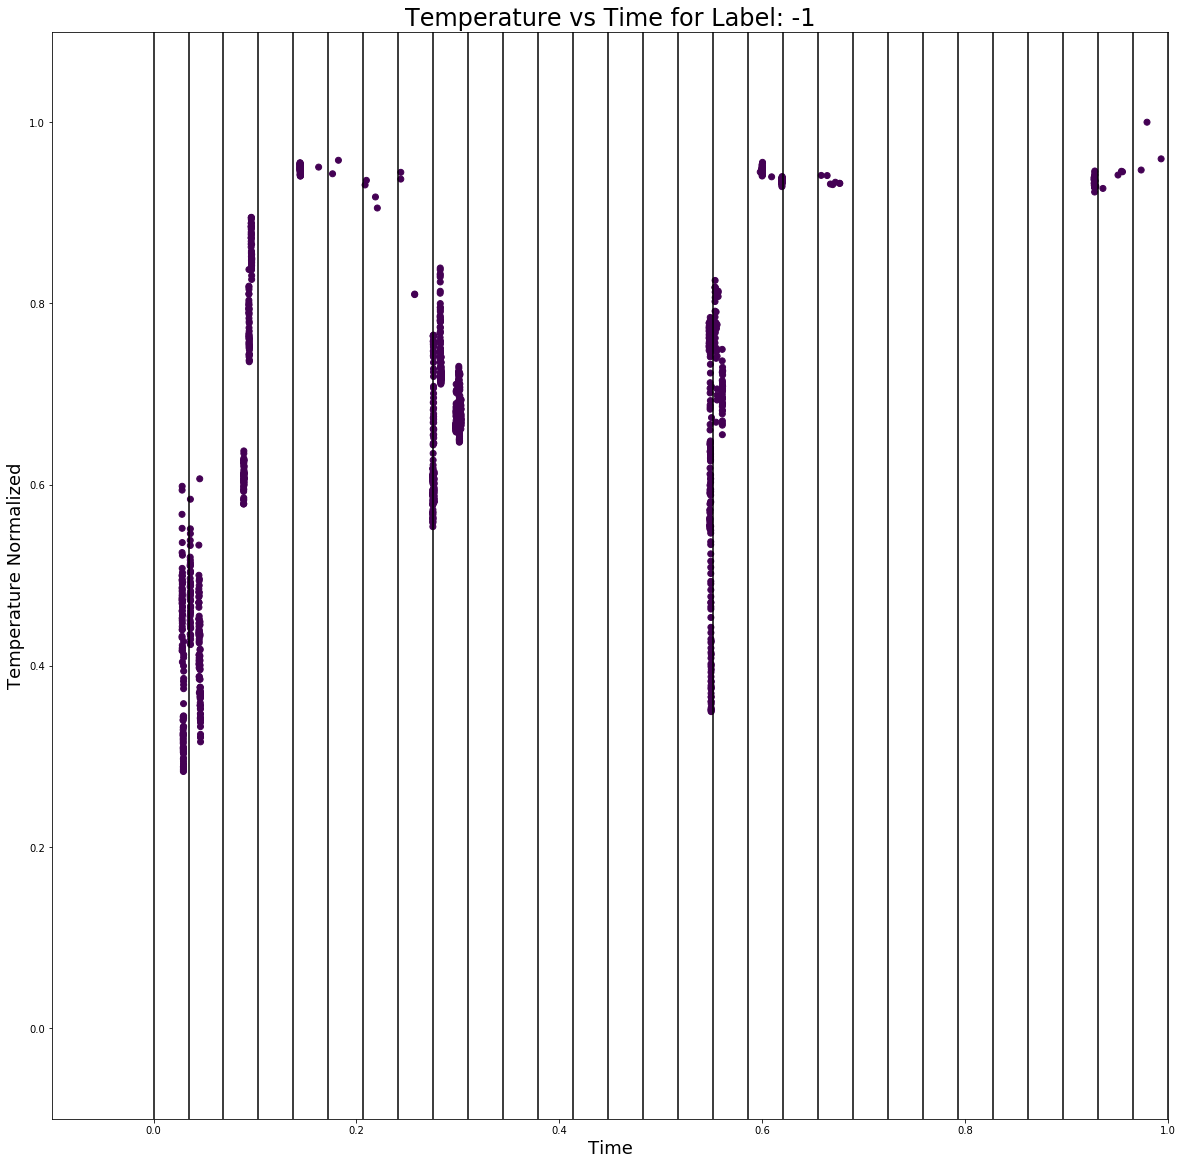

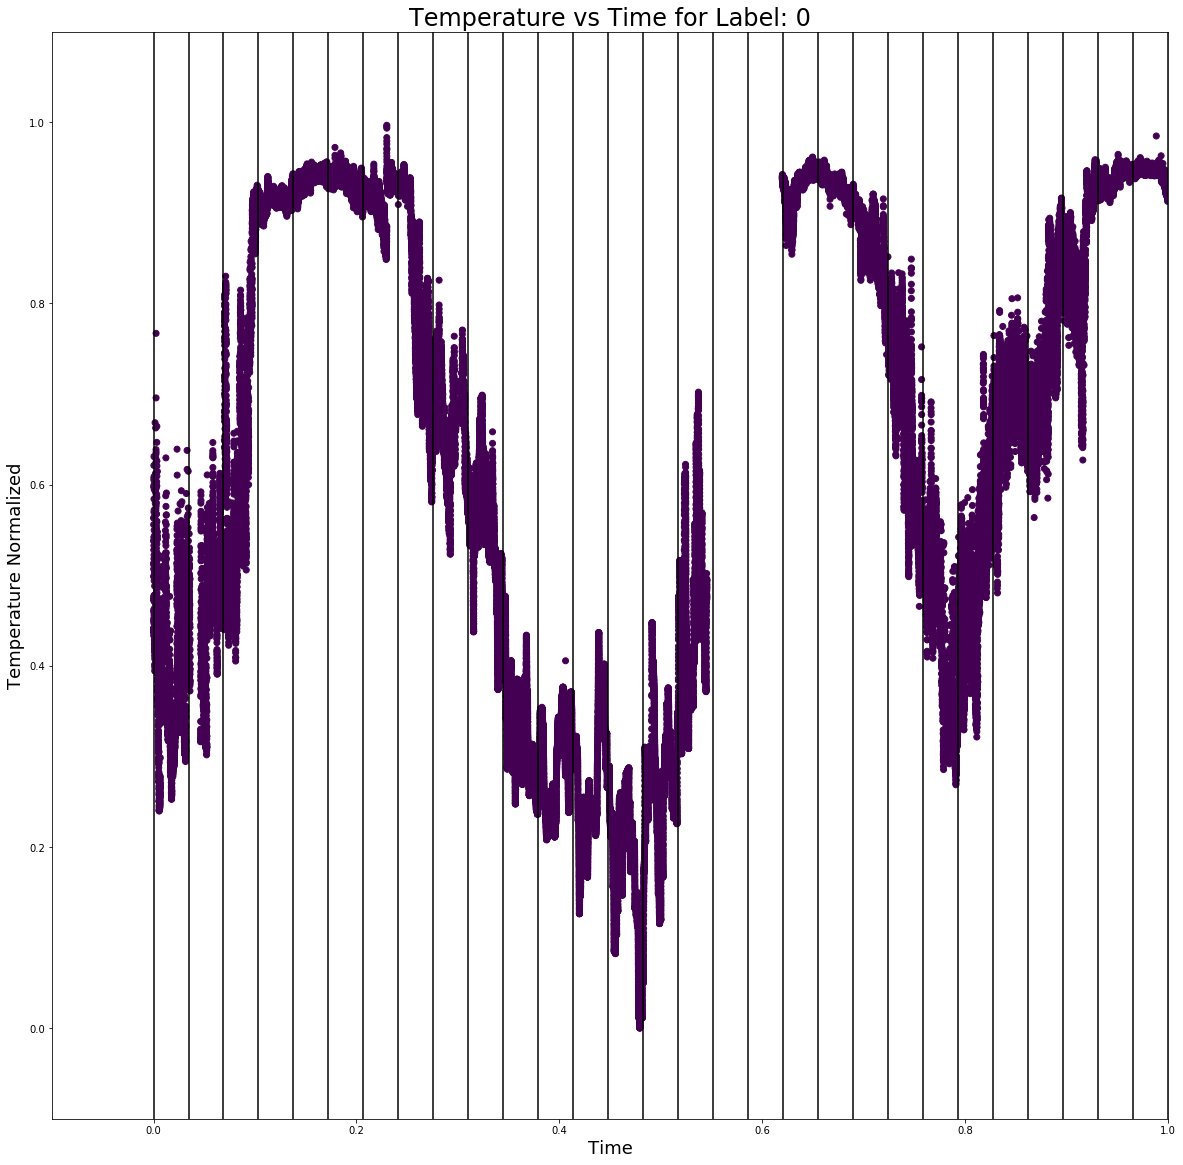

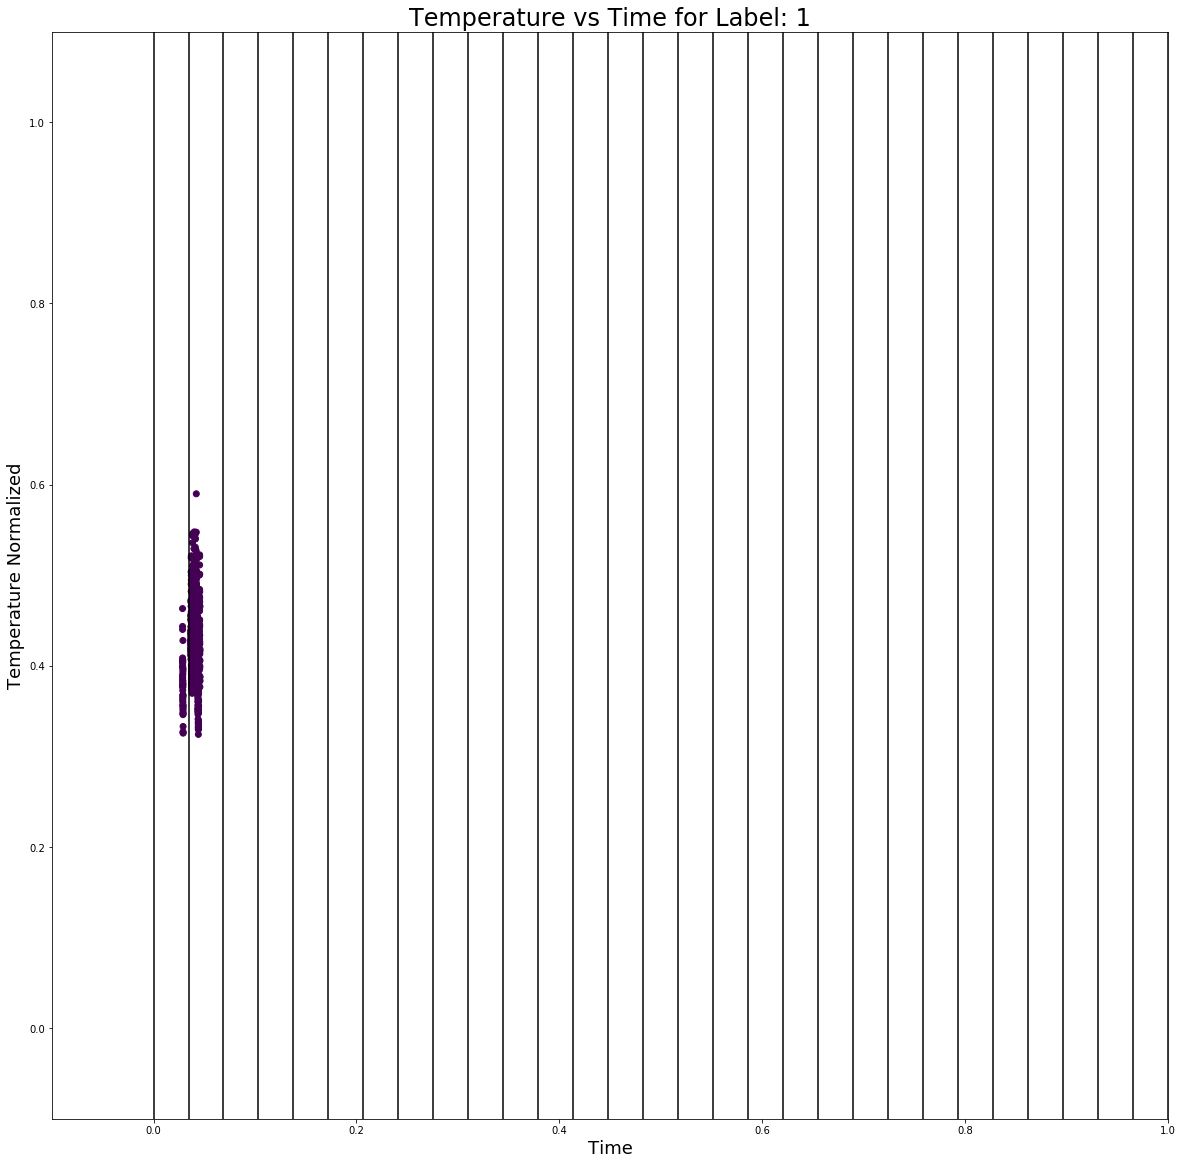

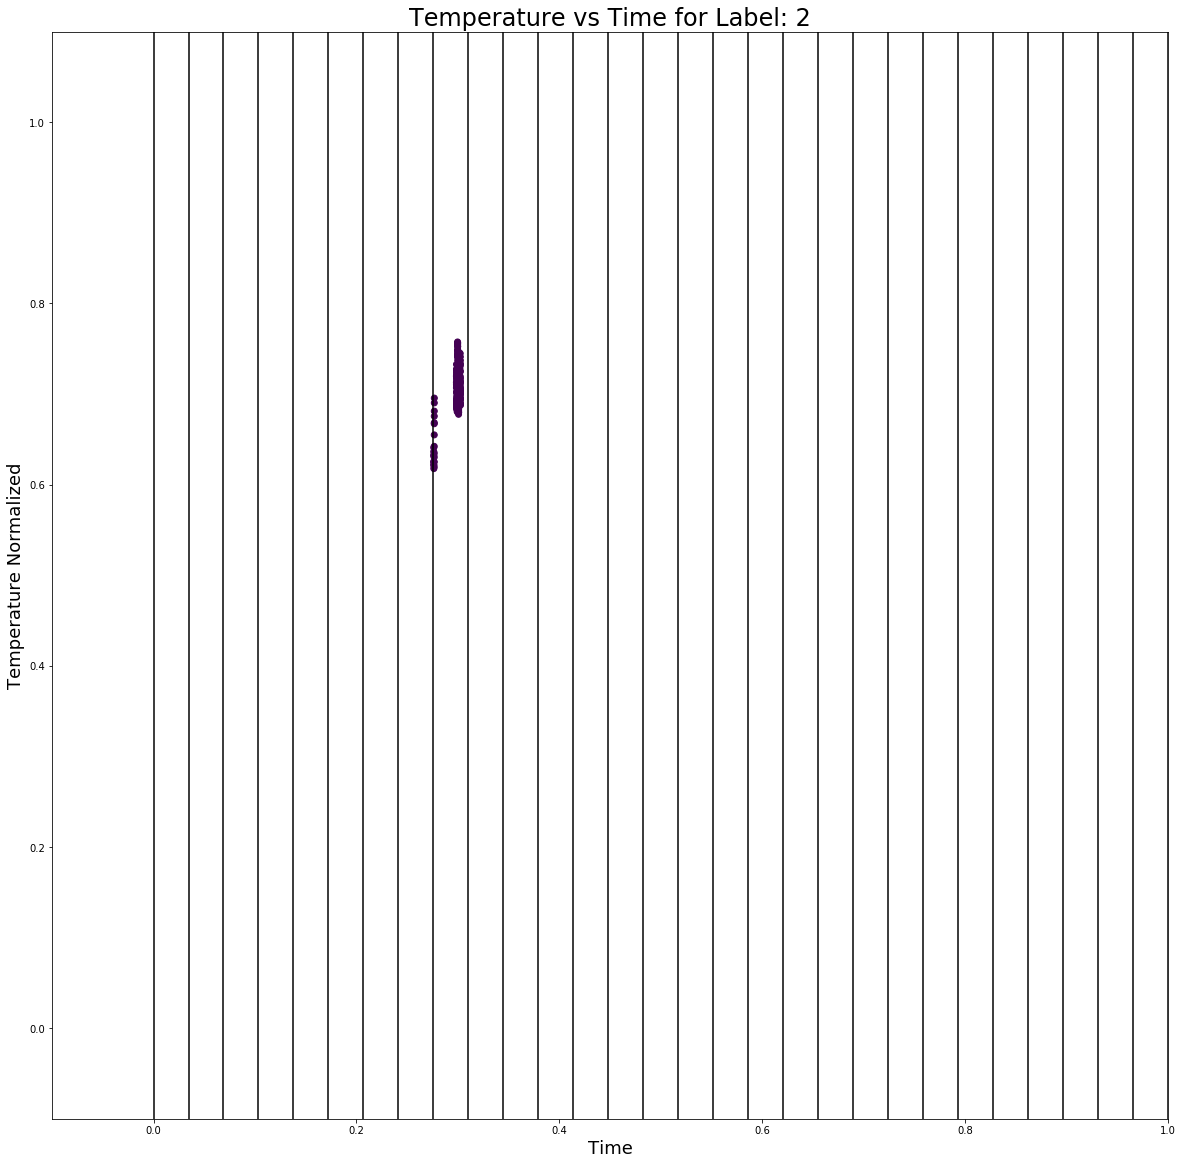

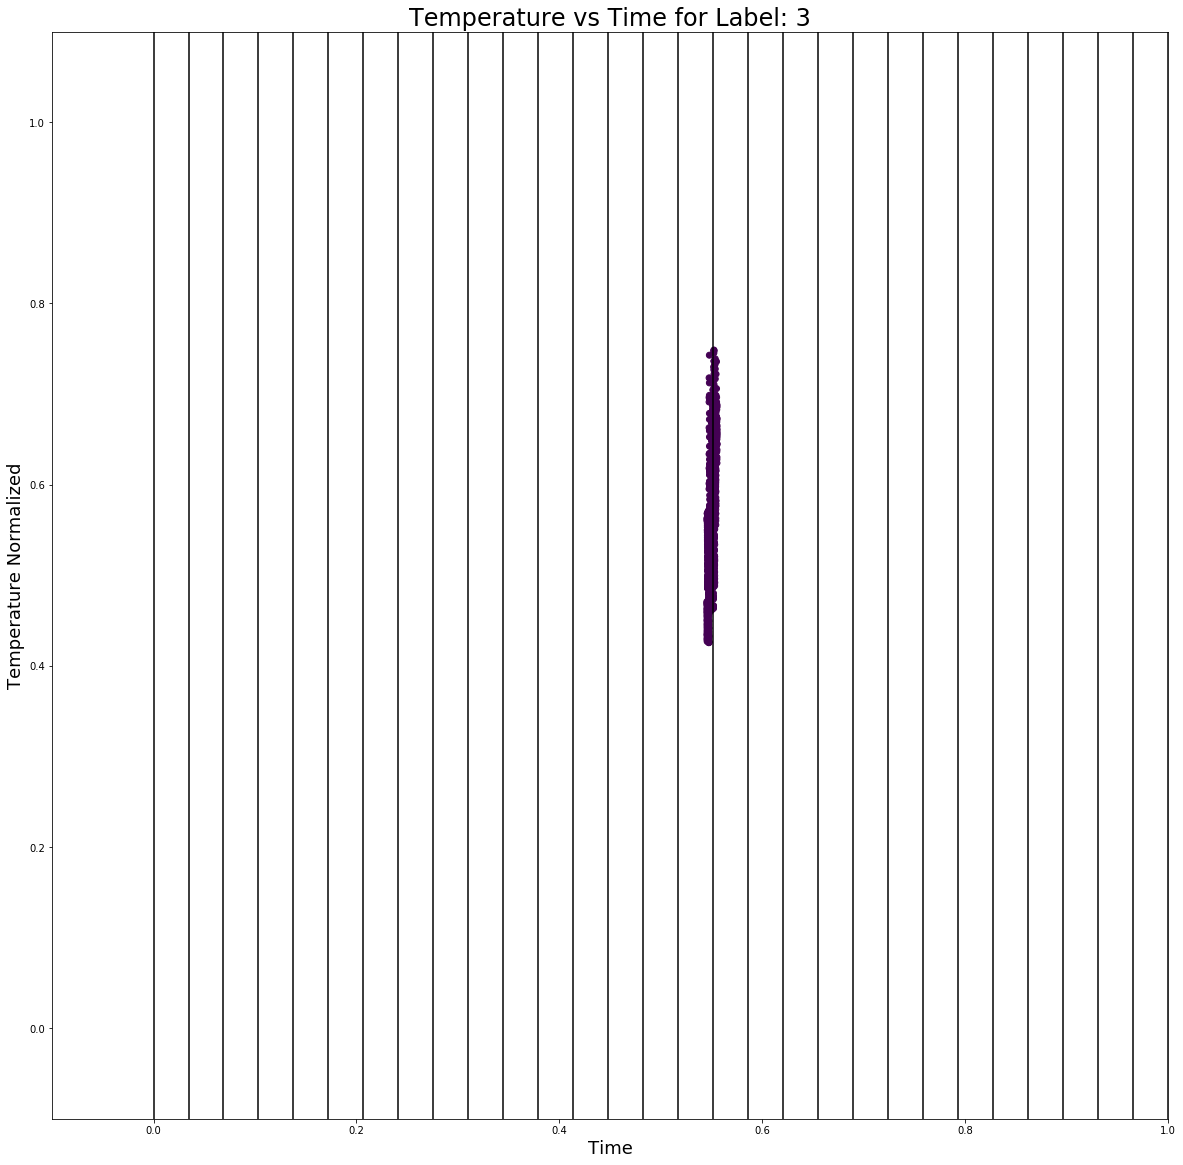

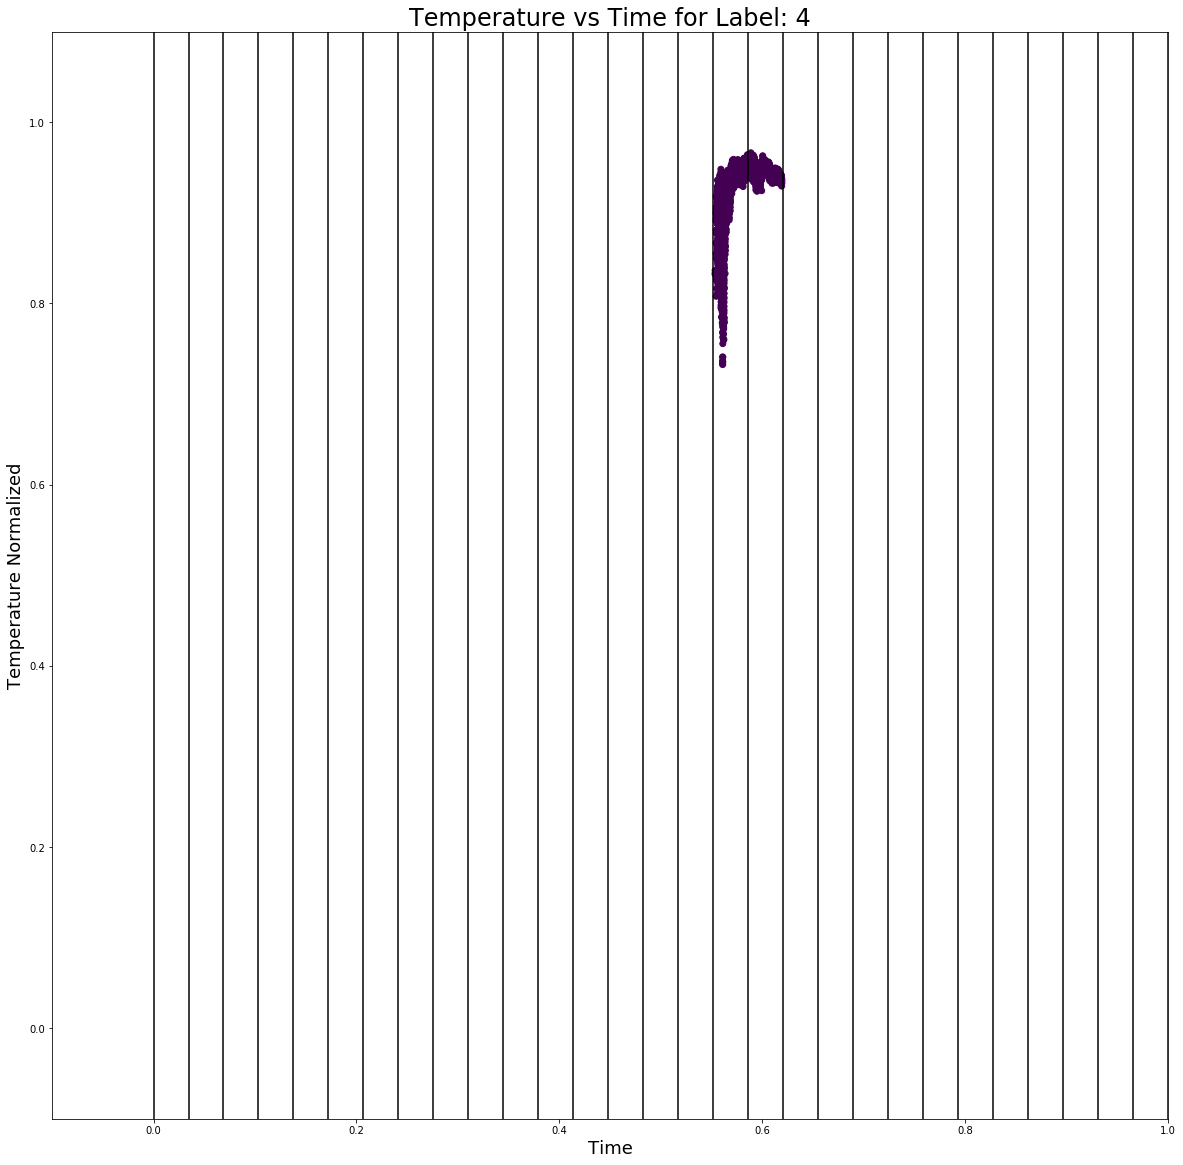

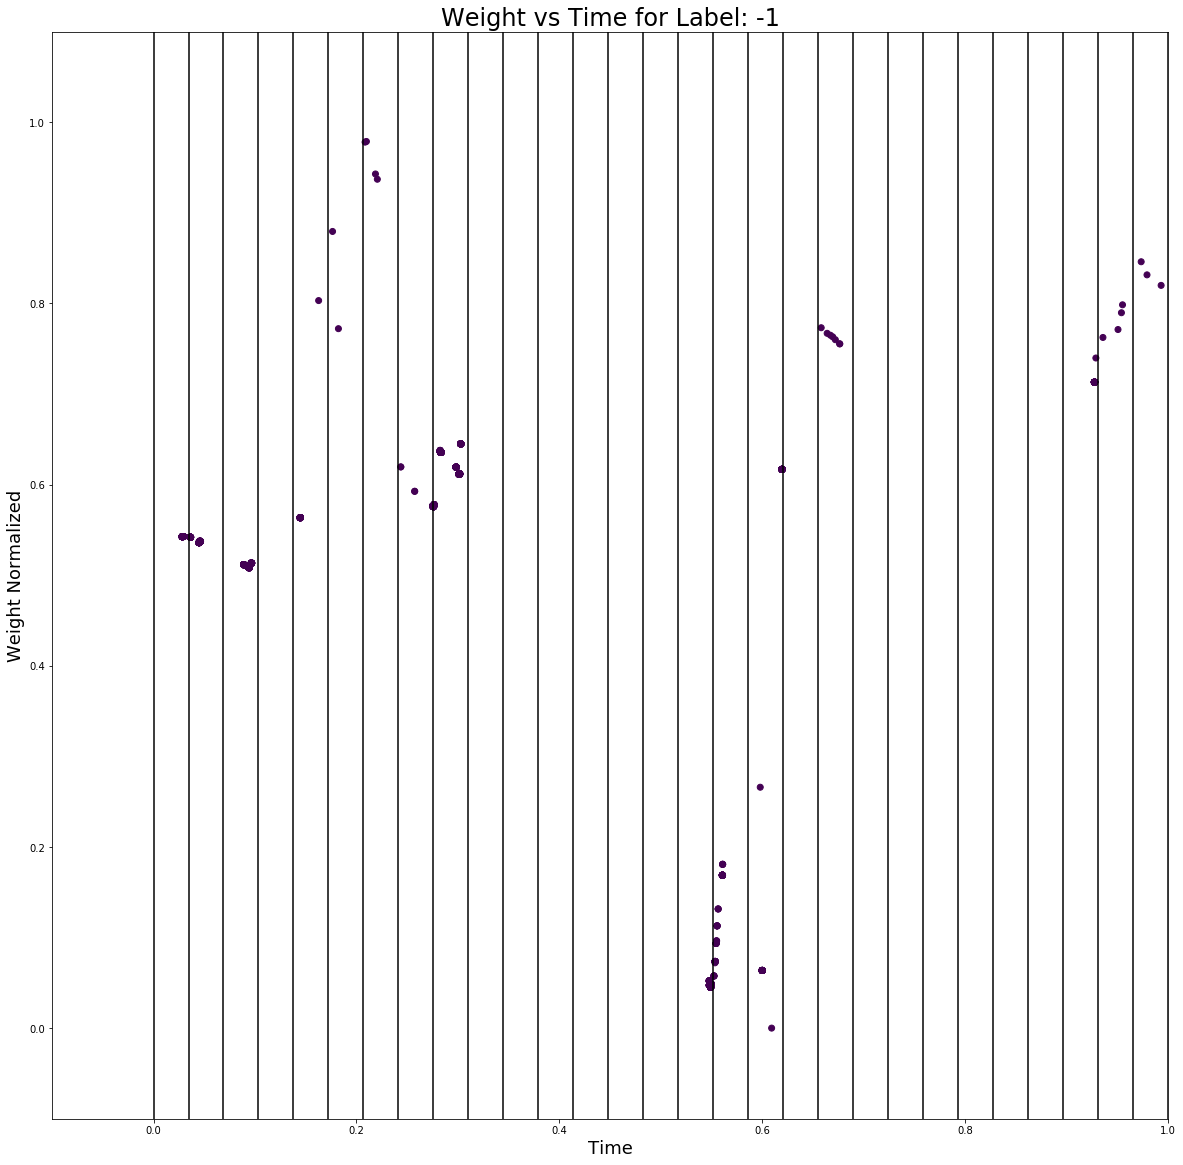

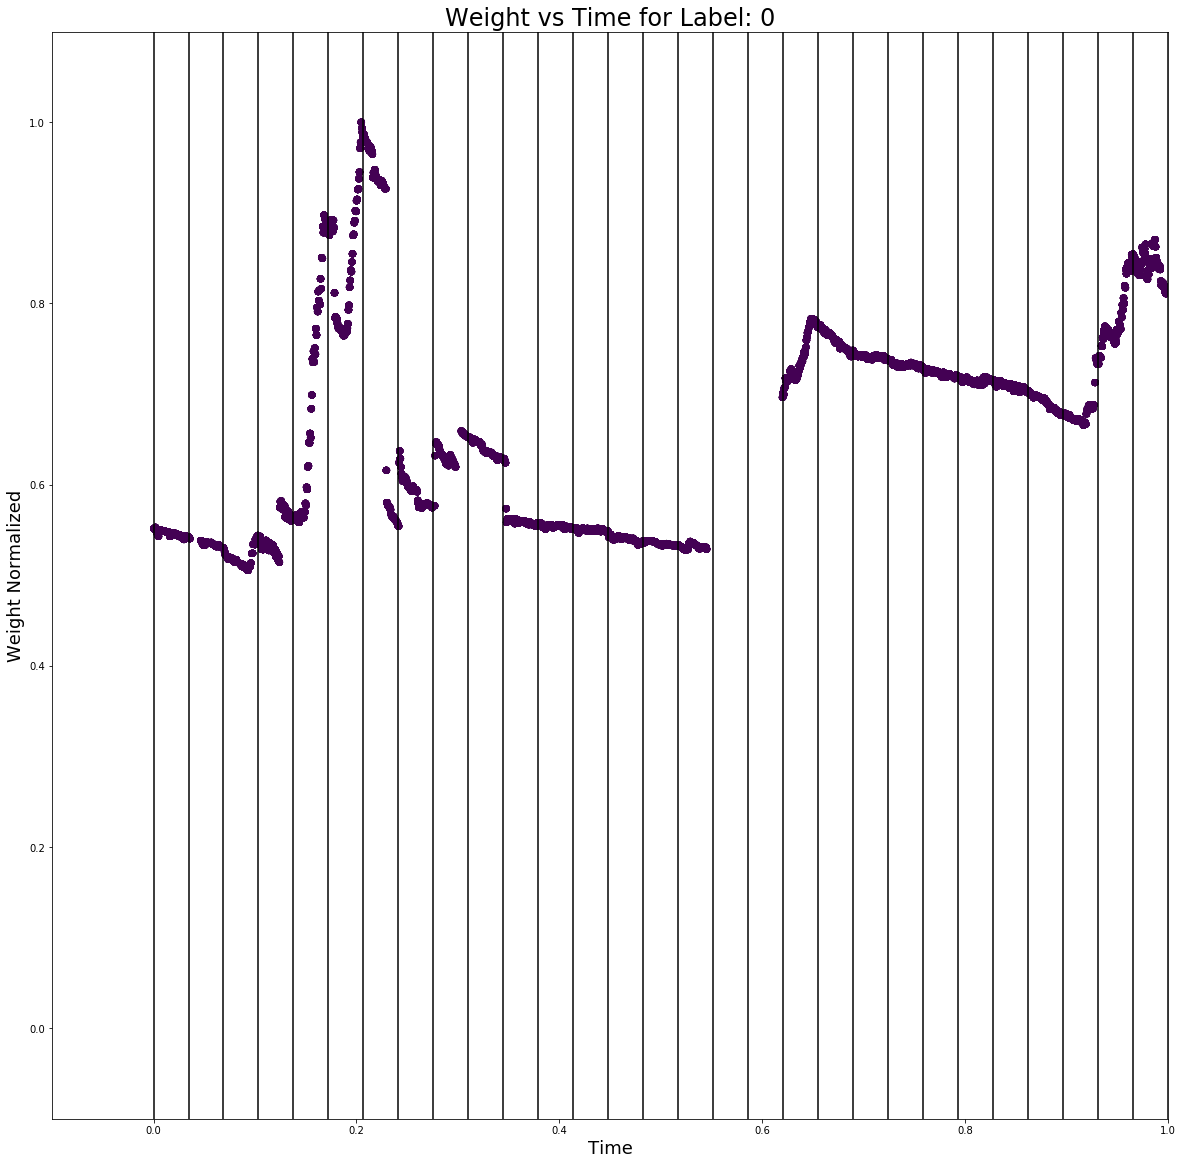

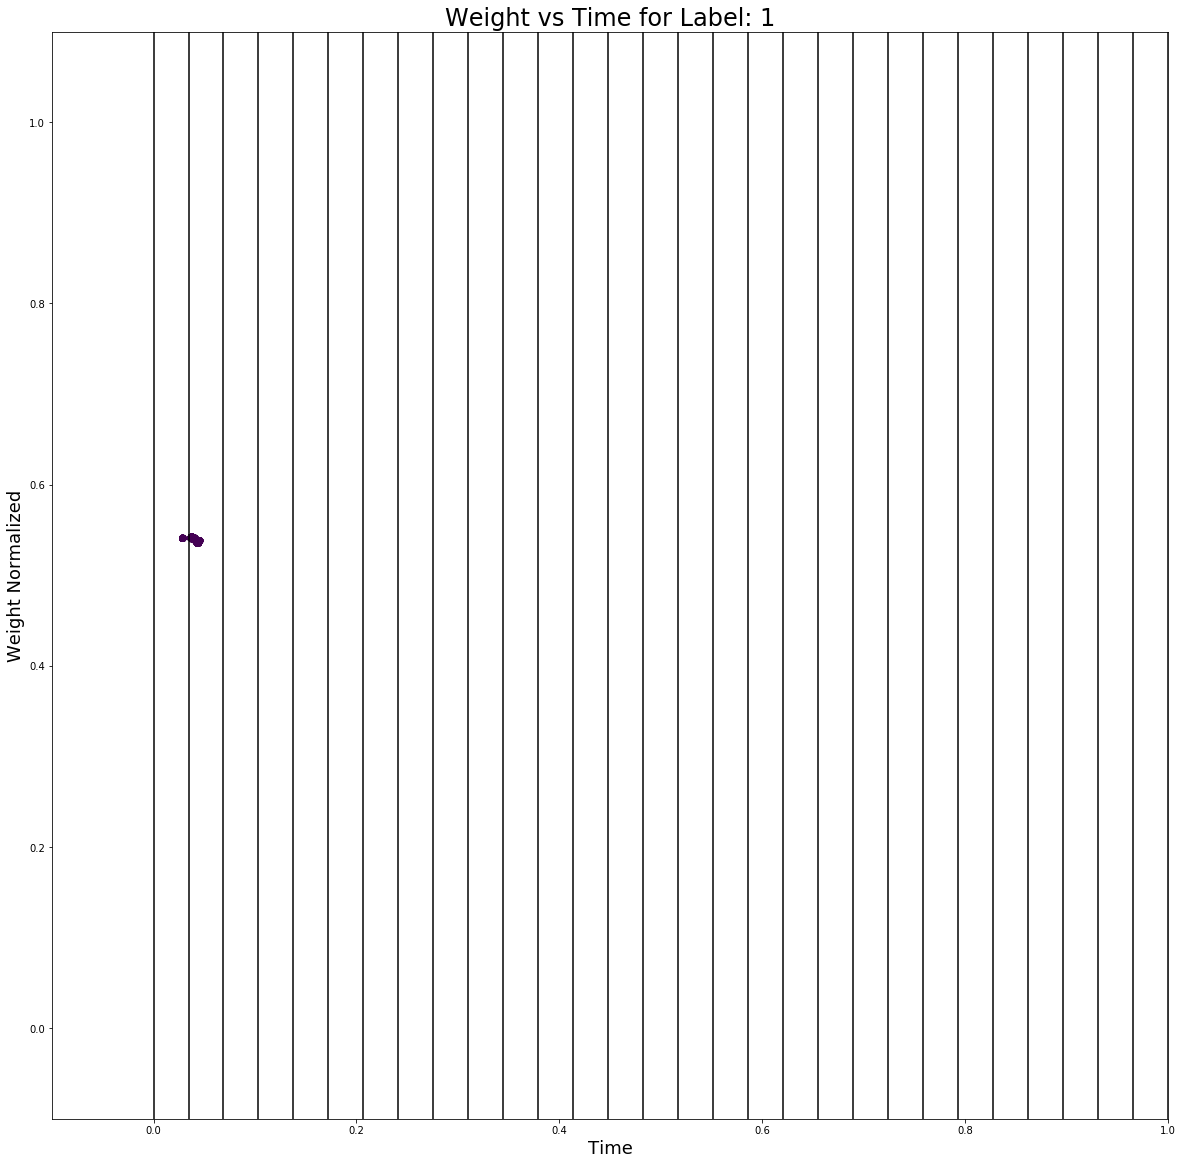

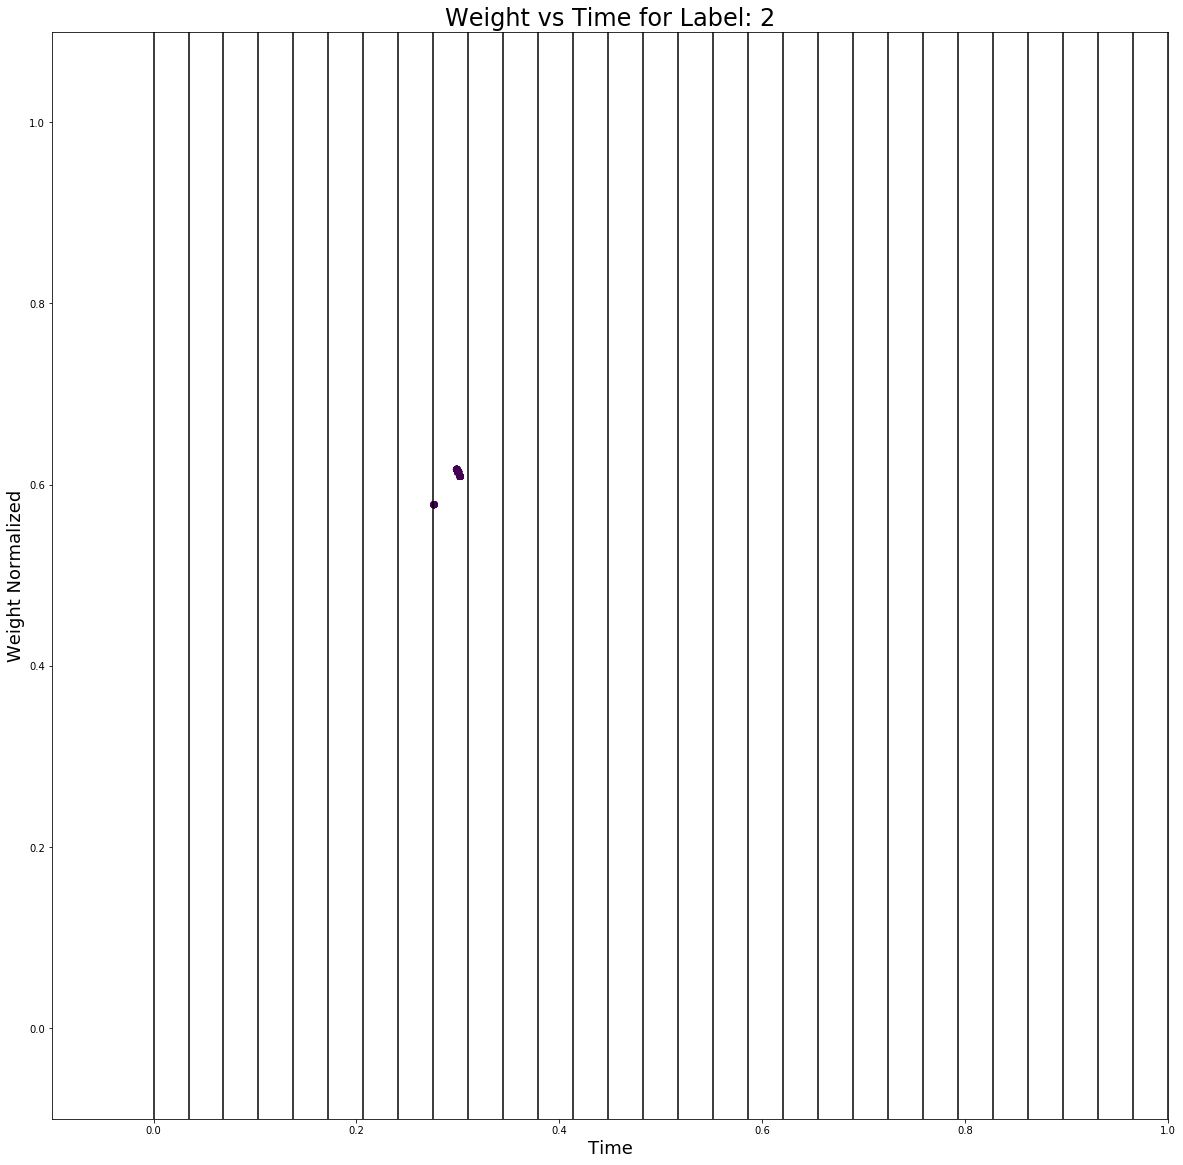

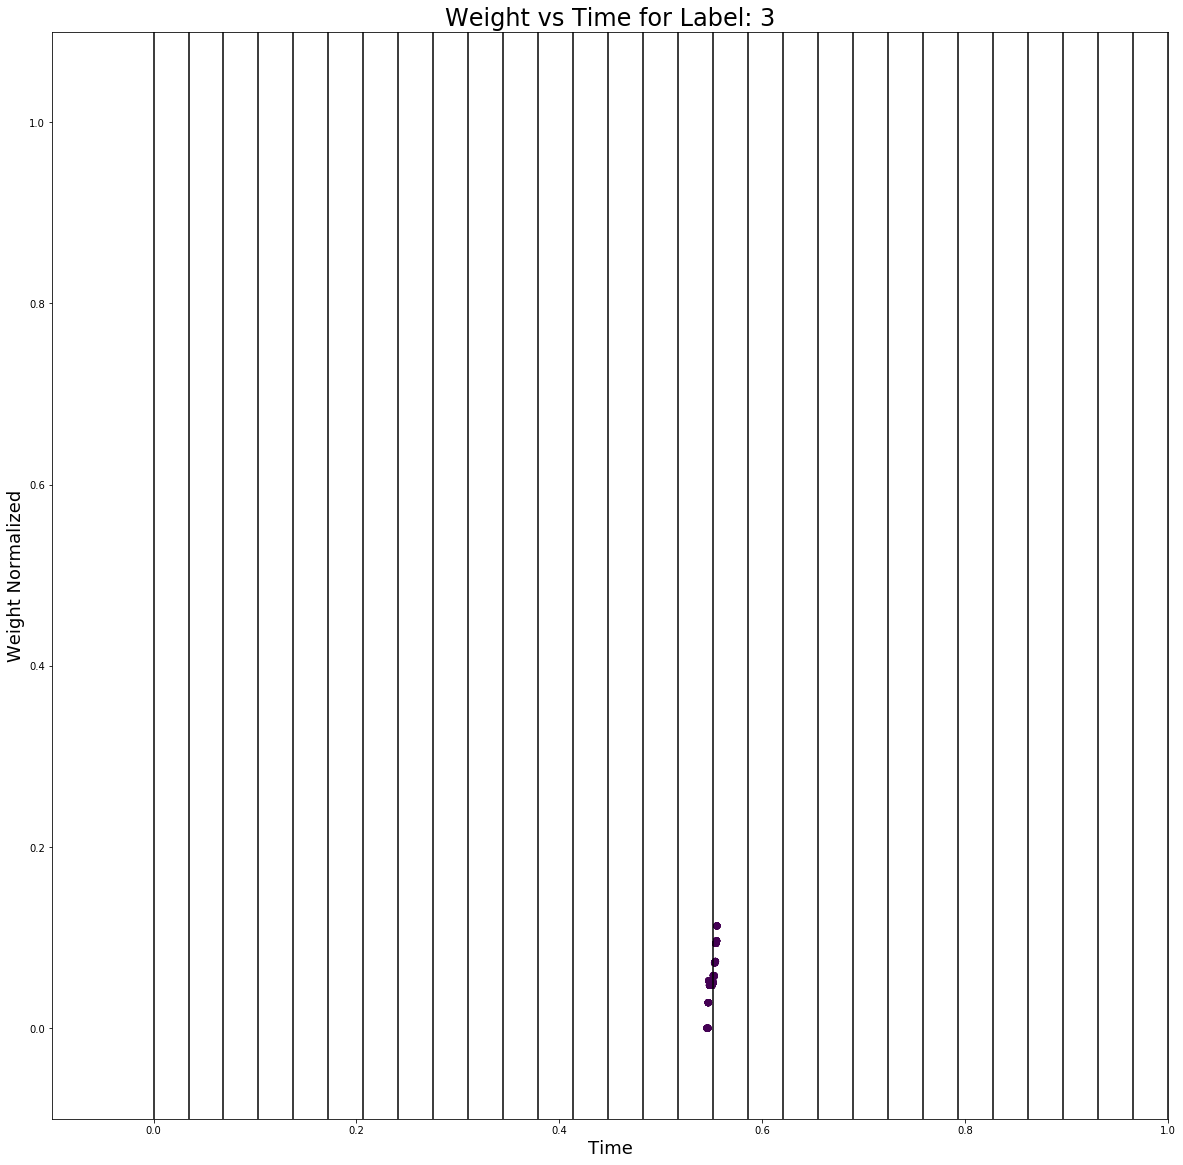

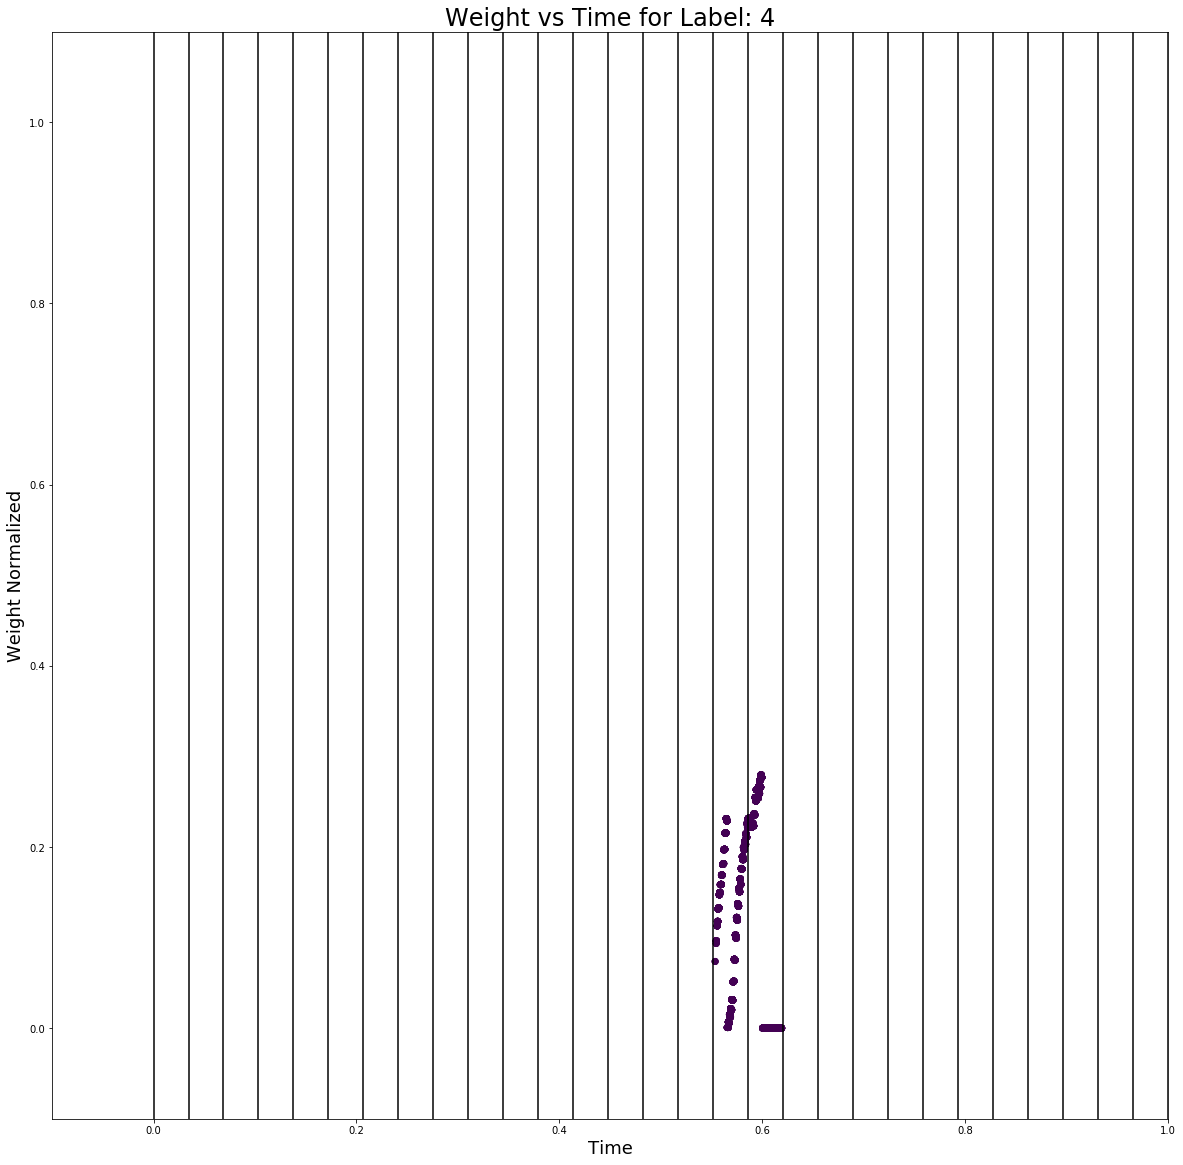

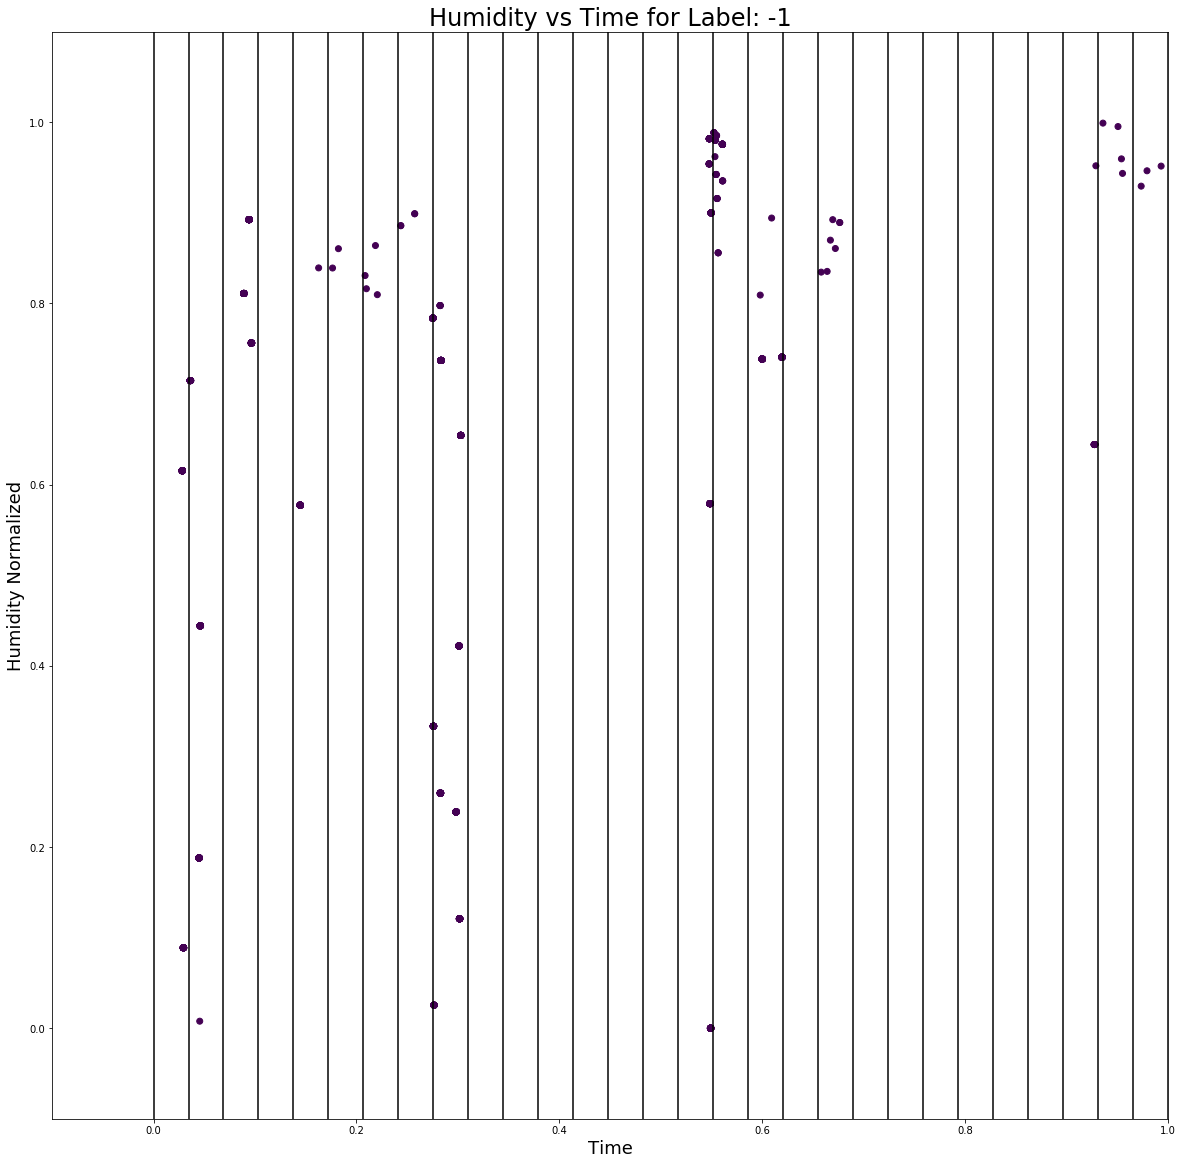

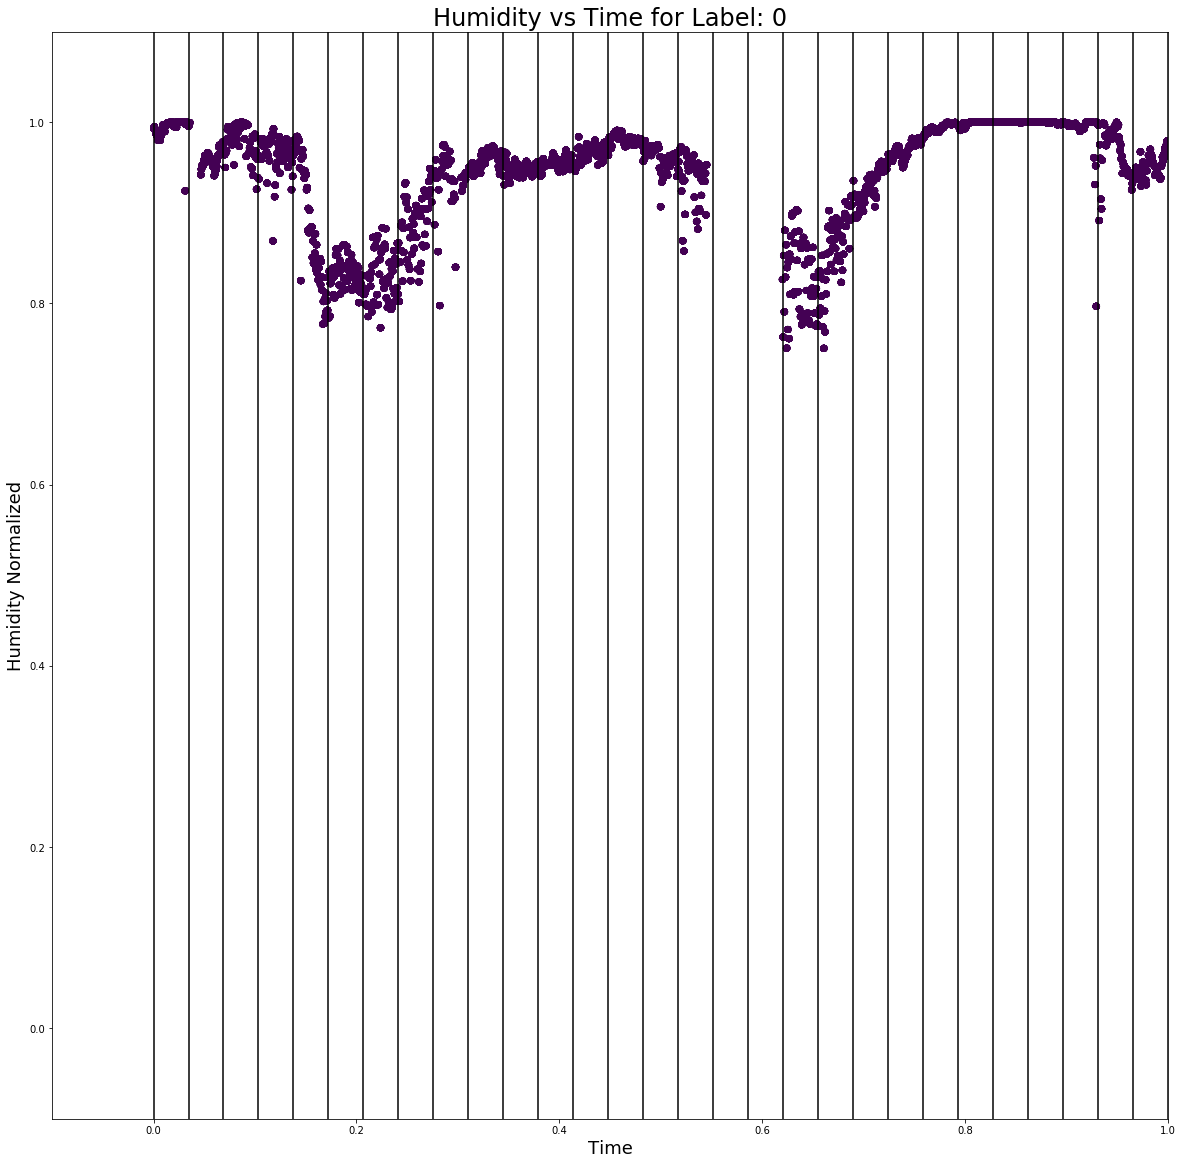

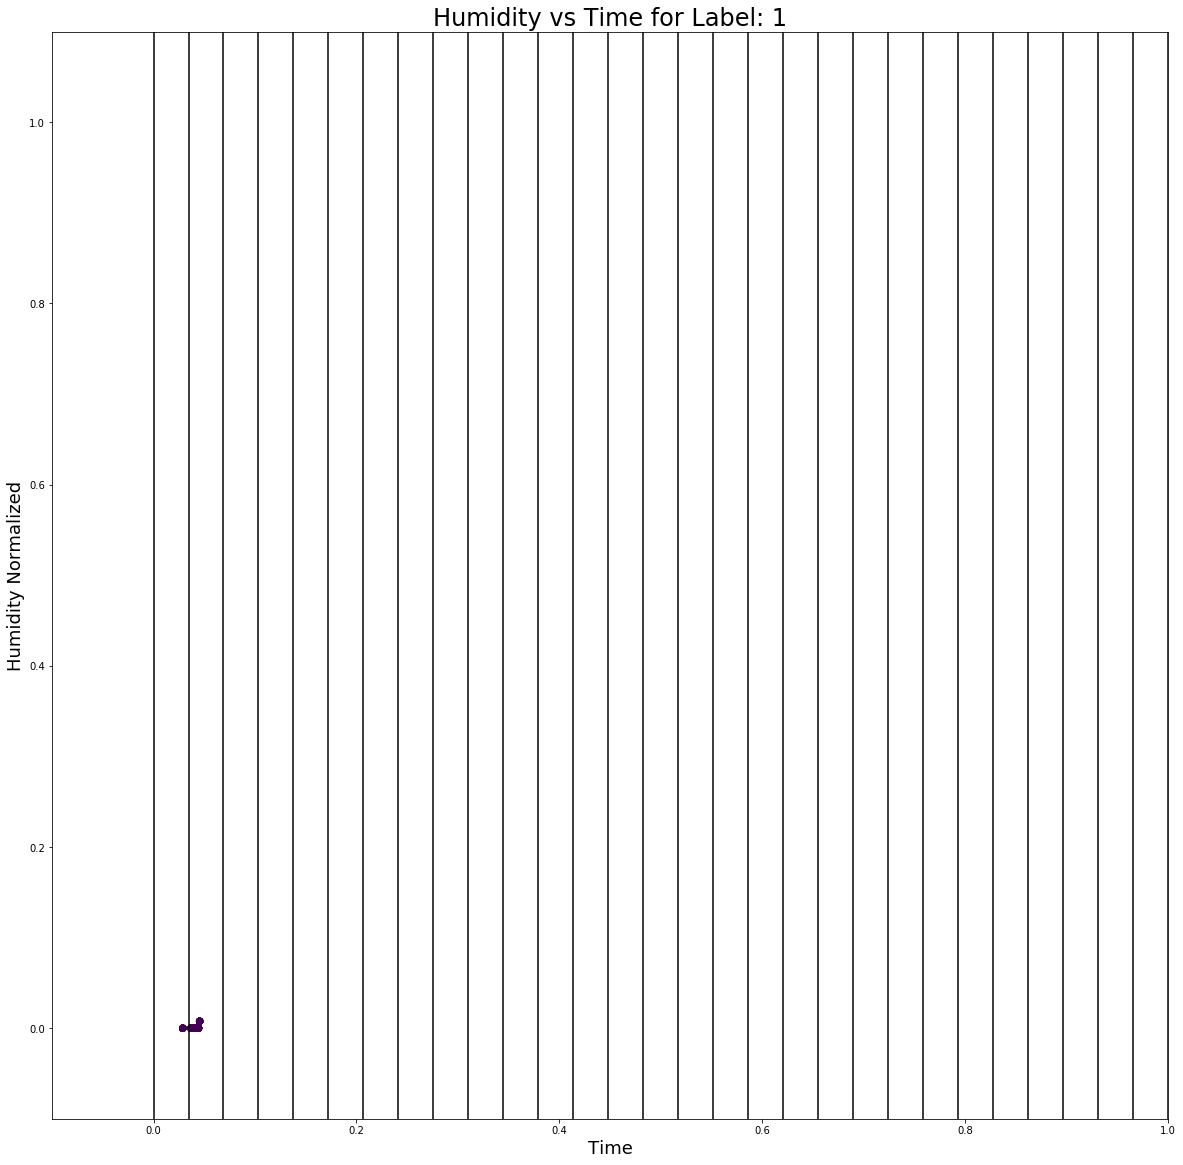

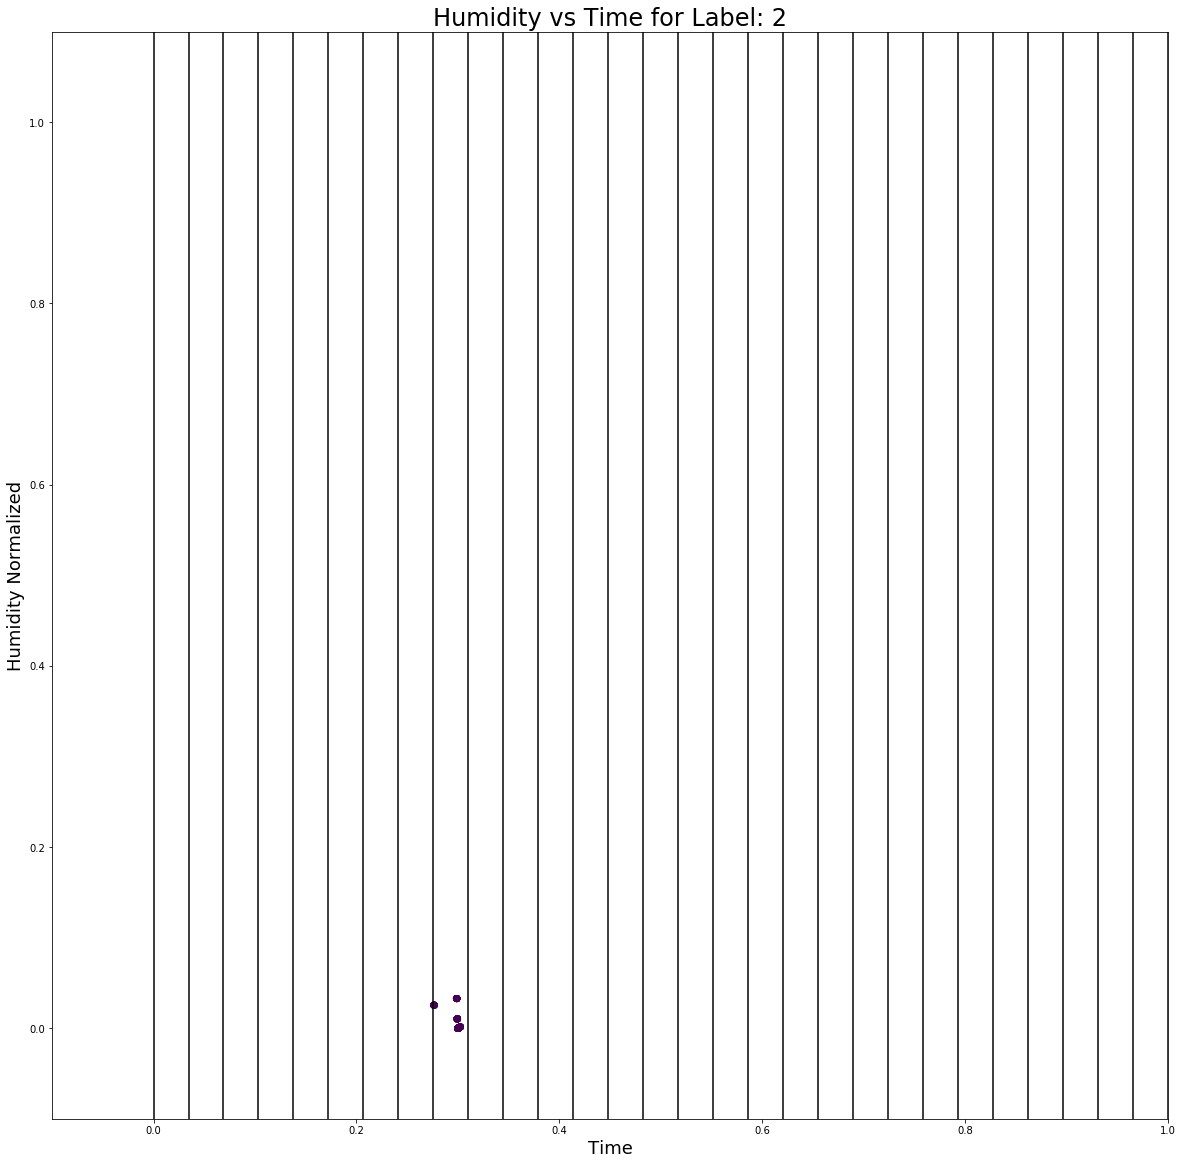

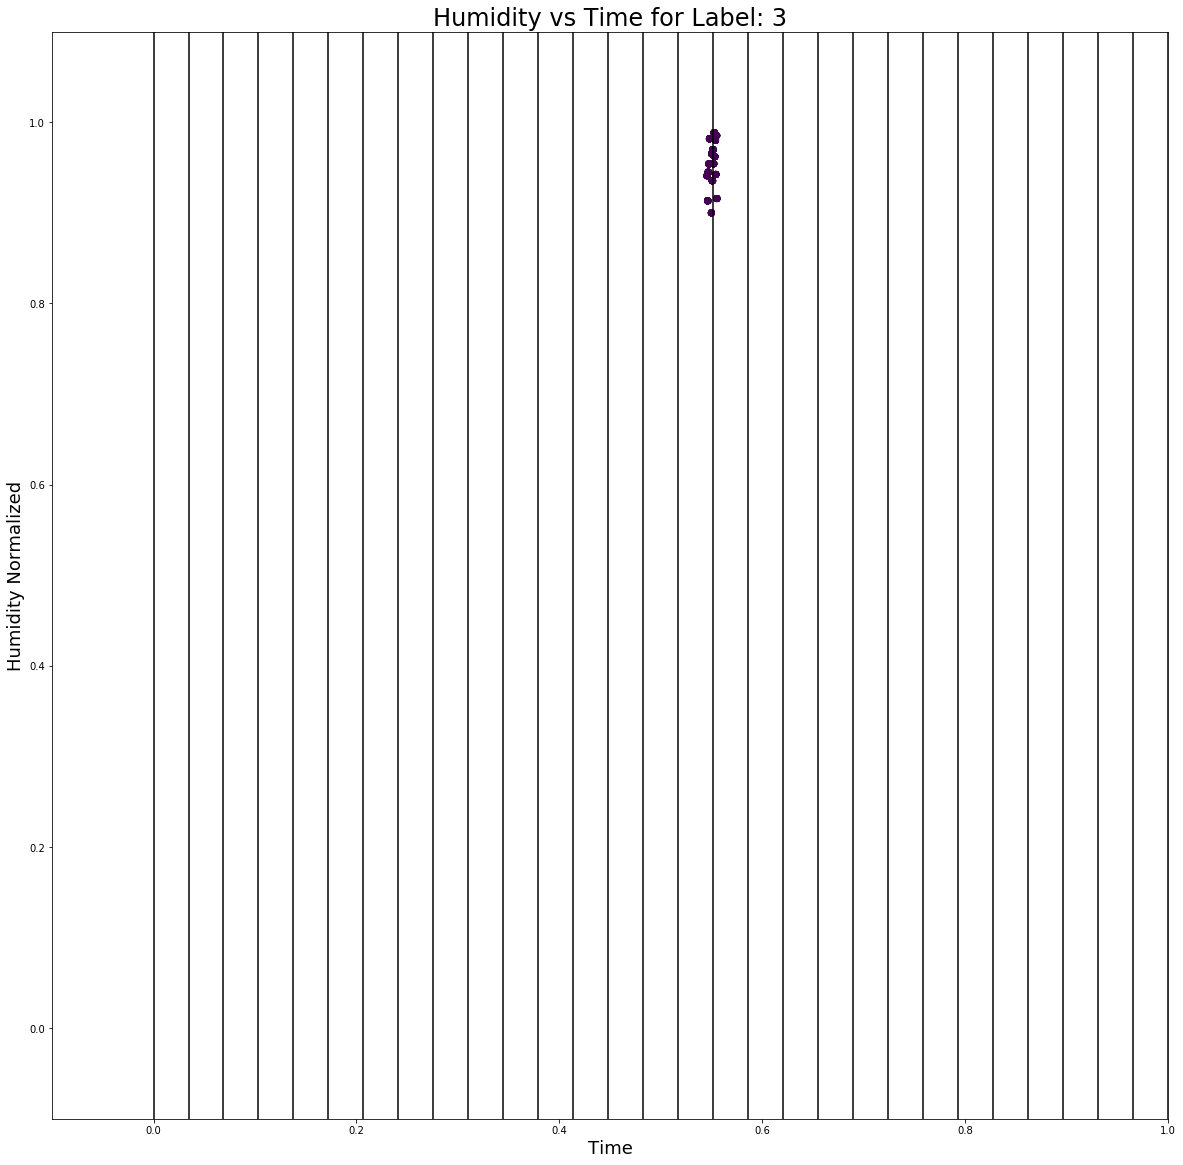

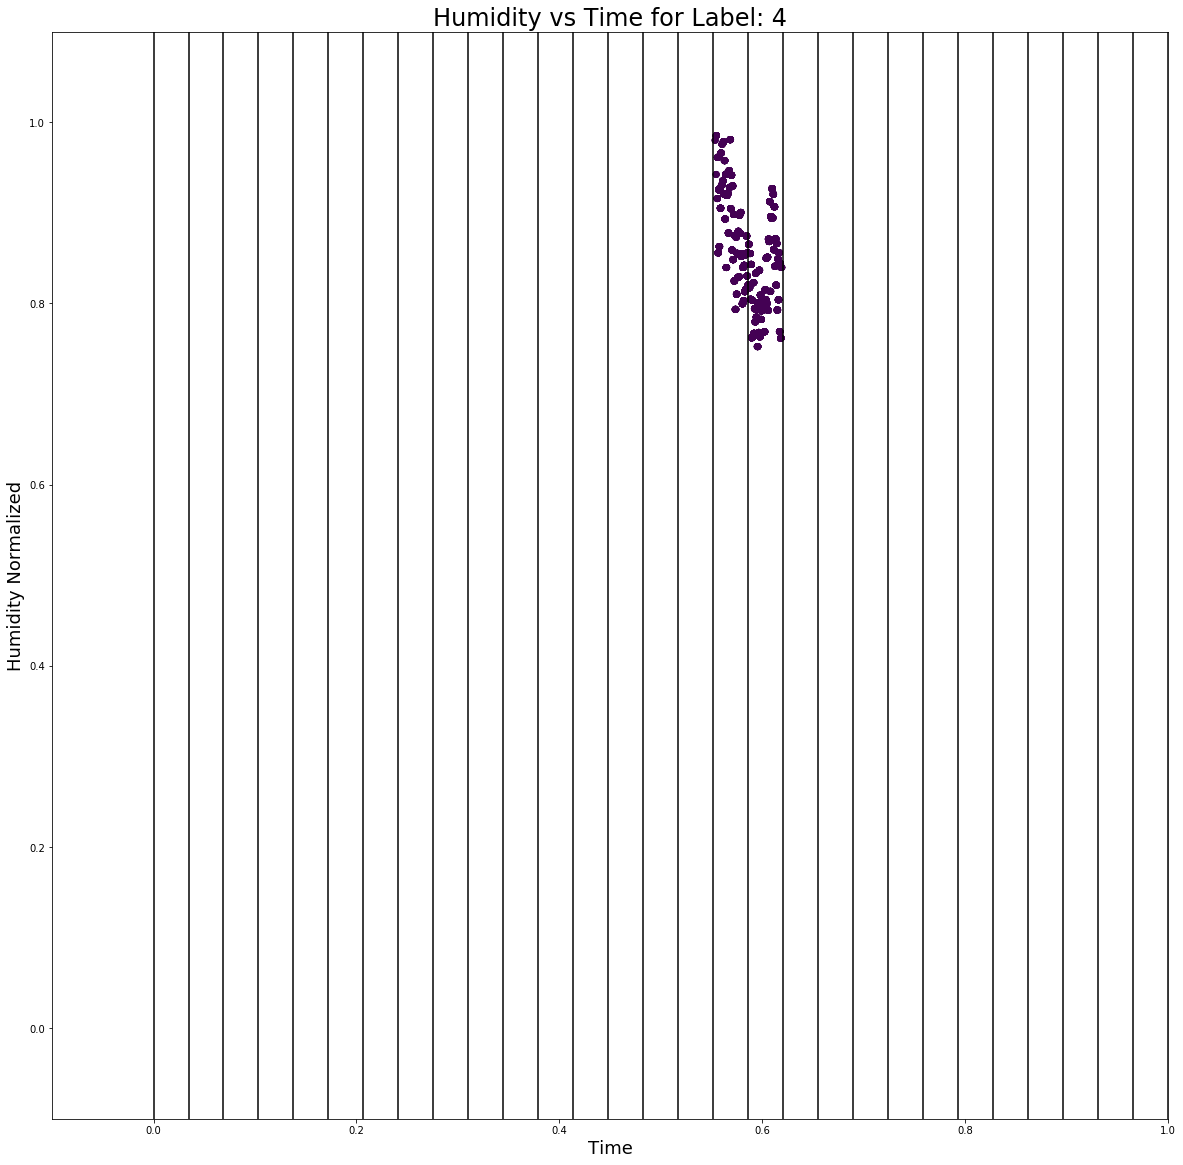

In [248]:
#Graph each attribute per label
for attribute, column in [['Flow', 3], ['Temperature', 2], ['Weight', 1], ['Humidity', 0]]:
    for label in range(-1, clusters):
        plt.figure(figsize=(20,20))
        indexes = [index for index, lbl in enumerate(labels) if lbl == label]
        plt.title(f'{attribute} vs Time for Label: {label}', fontsize=24)
        plt.ylabel(f'{attribute} Normalized', fontsize=18)
        plt.xlabel('Time', fontsize=18)
        for i in range(30):
            plt.axvline(x=i/29, c='black')
        plt.xlim(right=1)
        plt.xlim(left=-0.1)
        plt.ylim(top=1.1)
        plt.ylim(bottom=-0.1)
        plt.scatter(timestamps[indexes], X[:,column][indexes], c=labels[indexes])